# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=1


파이썬 코드를 실행하기 전에 항상 모든 모듈을 reload 하도록 강제 설정

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [5]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [6]:
from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'zinc15')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_2_optimize_ReBADD', 'zinc15')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 599957
Number of vocabulary: 44766
Maximum of seqlen: 44


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 44,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after  = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining_ReBADD', 'zinc15', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [13]:
from ReBADD_config import Reward_bcl2_bclxl_bclw as Reward

## 2-1) RL design

In [14]:
my_reward_ft = Reward(use_cuda=gpuconfigs.use_cuda, device=gpuconfigs.device)

[DEBUG] BA(navitoclax,P10415) = 9.745 (GT:9.745)
[DEBUG] BA(navitoclax,Q07817) = 7.524 (GT:7.524)
[DEBUG] BA(navitoclax,Q92843) = 6.597 (GT:6.597)
[DEBUG] SA(navitoclax) = 4.131 (GT:4.131)


In [15]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft)

## 2-2) Training

In [16]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [17]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [18]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [19]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [20]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, filepath):
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "BA_A":ba_A_list,
                               "BA_B":ba_B_list,
                               "BA_C":ba_C_list,
                               "EXEC_TIME":execution_times})
    df_history.to_csv(filepath, index=False)
    return df_history

In [21]:
# Setting up some parameters for the experiment
n_iterations = 500
checkpoint_stepsize = 10
behavior_stepsize = 20

[0001] rl_loss: 0.832	reconst_loss: 0.740	entropy_loss: 0.092	reward: 0.519	tau: 0.302	(24.884 sec)
[0002] rl_loss: 1.054	reconst_loss: 0.963	entropy_loss: 0.091	reward: 0.547	tau: 0.305	(50.225 sec)
[0003] rl_loss: 0.764	reconst_loss: 0.669	entropy_loss: 0.094	reward: 0.451	tau: 0.306	(75.052 sec)
[0004] rl_loss: 0.798	reconst_loss: 0.699	entropy_loss: 0.100	reward: 0.697	tau: 0.310	(100.415 sec)
[0005] rl_loss: 1.211	reconst_loss: 1.113	entropy_loss: 0.098	reward: 0.751	tau: 0.314	(126.736 sec)
[0006] rl_loss: 0.810	reconst_loss: 0.711	entropy_loss: 0.099	reward: 0.536	tau: 0.317	(151.150 sec)
[0007] rl_loss: 0.964	reconst_loss: 0.863	entropy_loss: 0.101	reward: 0.660	tau: 0.320	(175.392 sec)
[0008] rl_loss: 0.874	reconst_loss: 0.771	entropy_loss: 0.102	reward: 0.555	tau: 0.322	(199.063 sec)
[0009] rl_loss: 1.037	reconst_loss: 0.931	entropy_loss: 0.106	reward: 0.645	tau: 0.326	(223.499 sec)
[0010] rl_loss: 1.061	reconst_loss: 0.952	entropy_loss: 0.109	reward: 0.824	tau: 0.331	(248.05

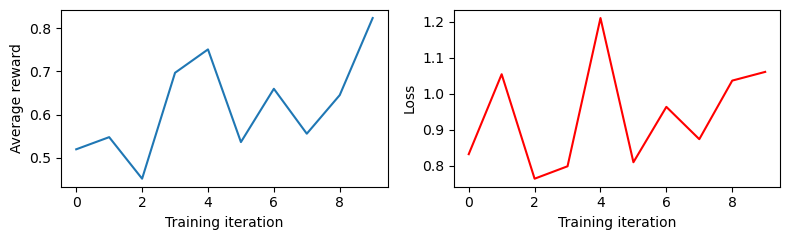

100%|██████████| 100/100 [00:03<00:00, 31.69it/s]


Sample trajectories: 100
[6.685, 6.530, 6.882, 0.179, 0.134, 0.582]    O=CCCC1=C[NH1]C=CC=CC=C1C=CC(C2=C3C=CC=C2)(NC3=O)S
[5.752, 5.494, 4.690, 0.030, 0.018, 0.010]    CCOC(=O)CC(=O)C(C(=O)C1=CC=CC=N1)C2CCN(CC2)C(=O)C(C3=CC=CC=C3)C4=CC=CC=C4
[6.507, 6.675, 6.031, 0.129, 0.176, 0.134]    CCC(C)NC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC=C2Cl)C(=O)CN(C3=CC(OC)=CC=C3OC)S(=O)(=O)C4=CC=C(C)C(=C4)[N+1](=O)[O-1]
[5.822, 6.625, 6.506, 0.034, 0.160, 0.316]    COC1=CC(=C(C)C=C1Br)C(=O)NC2=CC(C(N)=O)=CC=C2N3CCC(CC3)CC4=CC=CC=C4
[5.704, 4.896, 5.634, 0.027, 0.005, 0.063]    CCOC=CCOC=CCOC=CC=C1C=C(C2=CC=CC=C2)N(C1=O)C3=CC=C(C=C3)[N+1](=O)[O-1]
[6.237, 5.890, 5.889, 0.077, 0.039, 0.103]    CCOC1=CC=CC=C1N(S(C)(=O)=O)CCCC(=O)N(CC2=CC=CC=C2F)C(CC3=CC=CC=C3)C(=O)NC4CCCC4
[6.338, 5.534, 6.103, 0.093, 0.019, 0.154]    COC1=CC=C(Cl)C=C1S(=O)(=O)N2CCC(CC2)C(=O)NC3CCN(CC3)C4=CC(F)=C(F)S4
[5.732, 5.380, 6.163, 0.029, 0.014, 0.172]    O=CN=CNN=CC=CC1=CC(Br)=CC(Br)=C1OCC2=CC=CC=C2F
[4.802, 4.721, 4.609, 0.005, 0.004, 0.

[4.932, 4.679, 4.776, 0.006, 0.004, 0.012]    CCC(C)COCCNN1C(=O)C(SC1=S)=CC2=CC=C(C=C2)OCC3=CC=CC=C3
[5.537, 4.820, 4.877, 0.020, 0.005, 0.014]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C23)CN(C(C)=O)C=CC=C(N4CCOCC4)C(O)C(C)N3
[6.457, 5.732, 5.760, 0.117, 0.029, 0.080]    C1OC2=CC=C(C=C2)C=CC=CC(O)=CNC1C(C3=C[NH1]C4=CC5=CC=C34)C=CC([N+1](=O)[O-1])=C([NH1]5)C6=CC=C7C(=C6)OCO7
[5.783, 5.540, 5.895, 0.032, 0.020, 0.104]    C1CCC(=O)NCCCN(C(C)C)CCN(C1)C(=O)C2OC=CC3=CC(C)=C(C)C=C3C2=O
[5.754, 5.776, 5.790, 0.030, 0.031, 0.085]    CCCN(CCC)S(=O)(=O)C1=CC=C(C=C1)C(=O)NC2=NC(C3=CC=CC=C3)=C(S2)C4=CC=C(C=C4)C(C)(C)C
[5.314, 5.767, 5.370, 0.013, 0.031, 0.038]    COC1=CC=C(C(=C1)[N+1](=O)[O-1])N2C(C)=CC(=C2C)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[6.852, 6.542, 6.197, 0.242, 0.137, 0.183]    CC1=CC=CC=C1CN(C(CC2=CC=CC=C2)C(=O)NCC(C)C)C(=O)CN(S(=O)(=O)C3=CC=CC=C3)C4=CC(=CC=C4Cl)C(F)(F)F
[6.786, 7.054, 6.202, 0.215, 0.344, 0.185]    COC1=CC=C(Cl)C=C1N[CH0]2NC(=O)C(S2)CC3=CC=CC=C3CC=4C=C(C)N(

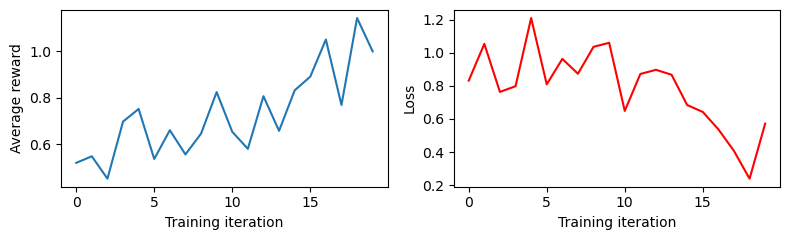

100%|██████████| 100/100 [00:02<00:00, 33.84it/s]


Sample trajectories: 100
[6.597, 7.414, 7.027, 0.152, 0.611, 0.720]    COC(=O)C1=CC=CC=C1C2=CC=C(O2)C3C(C4=CC=CC=N4)NC(=S)N3C5=CC=C(C=C5)NC6=CC=C(C)C(C)=C6
[6.435, 5.319, 5.629, 0.112, 0.013, 0.062]    O=C(NC1=CC=C(Br)C(Cl)=C1)CN2C(=O)SC(C2=O)=CC3=CC=C(C(Br)=C3)OCC4=CC=CC=C4Cl
[5.678, 5.752, 5.553, 0.026, 0.030, 0.054]    CCC(C(=O)NC(C)(C)C)N(CC1=CC=C(F)C=C1)C(=O)CN(C2=CC=C(C)C(Cl)=C2)S(=O)(=O)C3=CC=CC=C3
[5.992, 5.500, 5.884, 0.048, 0.018, 0.102]    CCC(C(=O)NC1CCCC1)N(CC2=CC=C(Cl)C(Cl)=C2)C(=O)CN(C3=CC=C(C)C=C3C)S(=O)(=O)C4=CC=CC=C4
[5.872, 5.787, 5.391, 0.038, 0.032, 0.039]    CCC(C(=O)NC1CCCC1)N(CC2=CC=C(Cl)C(Cl)=C2)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)C(O)=O
[6.104, 6.851, 6.142, 0.060, 0.241, 0.165]    CCOC1=CC=CC=C1N(S(=O)(=O)C2=CC=C(Cl)C=C2)CC(=O)N(CC3=CC=C(Cl)C=C3)C(C)C(=O)NC(C)(C)C
[6.371, 5.927, 6.208, 0.100, 0.042, 0.187]    CCC(C(=O)NC1CCCC1)N(CC2=C(Cl)C=CC=C2Cl)C(=O)CSCC3=CC=CC=C3F
[5.353, 4.826, 4.855, 0.014, 0.005, 0.014]    C1NCC=C1ONC2=CC=CC=C2Cl
[5.151, 4.726, 4.

[6.821, 7.478, 6.454, 0.229, 0.671, 0.289]    CC(C)(C)NC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(Cl)=C2)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[6.440, 5.970, 5.820, 0.113, 0.046, 0.090]    COC1=CC=C(C=C1)CN(C(C)C(=O)NC(C)(C)C)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.336, 6.883, 6.528, 0.093, 0.256, 0.329]    COC1=CC=C(C(=C1)[N+1](=O)[O-1])N2C(C)=CC(=C2C)C=C3C(=N)N4C(=NC3=O)SN=C4S(C)(=O)=O
[5.264, 5.491, 4.830, 0.011, 0.018, 0.013]    CCN(CC)C(=O)C1=C(C)N=C2SC(C(=O)N2C1C3=CC=C(Cl)C=C3)=CC4=CC=C(C(OC)=C4)[N+1](=O)[O-1]
[5.644, 4.585, 6.019, 0.024, 0.003, 0.132]    CC1=CC=C(C=C1)CN2C(=O)SC(C2=O)=CC=CC(OCC)=C(C(Br)=C)OCC3=CC=CC=C3
[5.737, 6.335, 5.335, 0.029, 0.093, 0.035]    CCOC1=CC=CC=C1N(S(=O)(=O)C2=CC=C(SC)C=C2)CC(=O)NC3=C(C)C=CC=C3C
[4.301, 4.013, 4.468, 0.002, 0.001, 0.006]    O=CNCSC1=NN=C(C2=CC=CN=C2)N1CCC3=CC=CC=C3
[6.410, 6.519, 6.474, 0.107, 0.131, 0.300]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(F)C=C1)C(=O)CN(C2=CC=C(C)C=C2)S(=O)(=O)C3=CC=C(Cl)C=C3
[4.854, 4.614, 5.085, 0.005, 0.003, 0.0

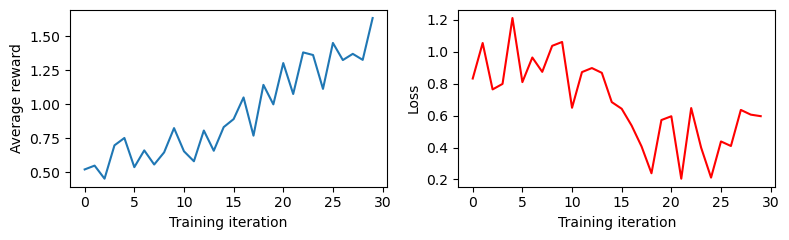

100%|██████████| 100/100 [00:03<00:00, 33.13it/s]


Sample trajectories: 100
[5.697, 5.227, 5.614, 0.027, 0.011, 0.061]    CC1=CC=C(C=C1)NC(=O)COC(=O)CCCC(=O)NC2=CC=C(C=C2)OC3=CC=C(Br)S3
[6.888, 7.243, 6.861, 0.258, 0.469, 0.564]    CCCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[4.186, 3.413, 4.255, 0.001, 0.000, 0.004]    C1NCOCCCO1
[6.448, 5.932, 5.549, 0.115, 0.043, 0.053]    C1C(=NC2=CC=C(Br)C=C12)CC=C3C=C(C(=O)N3CC4=CC=C(Cl)C=C45)OC(=O)OC5
[7.859, 8.566, 7.225, 1.116, 2.244, 0.944]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(OC)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.016, 5.916, 6.612, 0.050, 0.041, 0.379]    CC1=CC(=NO1)C2=CC=C(O2)C3C(C4=CC=CC=N4)NC(=S)N3C5=CC=C(C=C5)N6C(=O)CSC6
[6.021, 4.506, 4.925, 0.051, 0.003, 0.016]    O=C(C1=CC=C(F)C=C1)NC(CCC2=CCCCC2)CC(=O)NS(=O)(=O)C3=CC=C(C=C3)C(C)(C)[N+1](=O)[O-1]
[5.736, 5.806, 6.037, 0.029, 0.033, 0.136]    O=CC(=CC1=CC=C(Cl)C=C1Cl)C(=O)N(C2=CC=CC=C2)C(=O)NC3=CC=C(Cl)C=C3
[6.297, 6.342, 6.320, 0.086, 0.094, 0.228]    COC1=CC=C(C=C1OC)CCNC(=O)C2=

[6.999, 7.252, 7.042, 0.313, 0.476, 0.736]    CCCCNC(=O)C(C)N(CCC1=CC=CC=C1)C(=O)CN(C2=CC(OC)=CC=C2OC)S(=O)(=O)C3=CC=CC=C3
[6.124, 6.042, 6.387, 0.062, 0.053, 0.257]    O=C(C1=CC=C(Br)C=C1)NC2=NC(=NC(C)=N2)C(=O)C3=CC=CC=C3NCC4=CC=CC=C4
[5.431, 4.960, 5.219, 0.016, 0.006, 0.028]    N1C2=CC=CC=C2C1C(=O)OC3OCC(N=C3)N4CCN(CC4)CC5=CC=C(C=C5)C(C)(C)C
[4.342, 4.054, 4.440, 0.002, 0.001, 0.006]    CNCCSCC1=C(F)C=CC=C1Cl
[6.567, 6.843, 6.561, 0.144, 0.238, 0.348]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1)C(=O)CN(C2=CC=CC=C2F)S(=O)(=O)C3=CC=C(C)C=C3
[5.863, 5.448, 5.112, 0.037, 0.016, 0.023]    CCOC1=CC=C(C=C1)C(C2=CC=CC=C2)NC(=O)CN(S(=O)(=O)C3=CC=CC=C3)C4=CC=C(C=C4)OC5=CC=CC=C5
[6.484, 6.043, 5.130, 0.123, 0.053, 0.023]    COC1=CC=C(C=C1)C(=O)N2CC3N(CC2)C4=CC=C(C=C4)NC(=O)C5=CC(=C(Cl)C=C5Cl)S(=O)(=O)NCCC(C(C)C)C3
[5.974, 6.114, 6.113, 0.046, 0.061, 0.157]    O=C=CCC1CCN(CC1)C(=O)C2=CC(F)=CC=C2OCC(F)(F)F
[7.504, 7.789, 7.131, 0.698, 1.023, 0.833]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)N

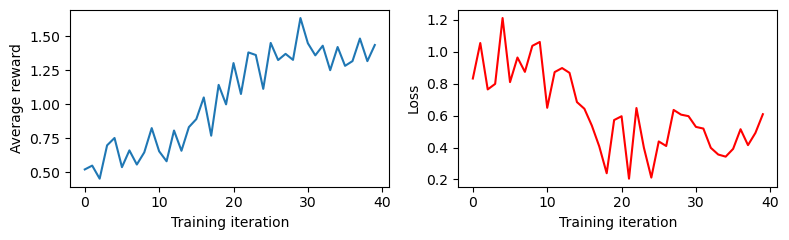

100%|██████████| 100/100 [00:03<00:00, 30.25it/s]


Sample trajectories: 100
[5.931, 6.229, 5.909, 0.042, 0.076, 0.107]    CCCN(CCOC)S(=O)(=O)C1=CC=C(C=C1)C(=O)NC2=CC(=CC=C2Cl)S(=O)(=O)N(C)C
[5.273, 4.941, 5.261, 0.012, 0.006, 0.030]    O=CCSC1=CC=CC=C1NC(=S)NC2=CC=C3OC(=NC3=C2)C4=CC(=CC=C4Cl)[N+1](=O)[O-1]
[6.688, 7.469, 7.464, 0.180, 0.663, 1.261]    CCC(C(=O)NCC(C)C)N(CC1=CC=CC(C)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C=C3
[8.329, 8.338, 7.016, 1.833, 1.848, 0.709]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.288, 7.632, 7.007, 0.503, 0.834, 0.700]    C=CC1=CC=C(C=C1)C2=CC(=C3C=C(C)C=CC3=N2)C(=O)NC4=CC=C(OC)C(=C4)CN(C)S(=O)(=O)N(C)C
[5.211, 5.698, 5.215, 0.010, 0.027, 0.028]    COC1=CC=C(C=C1OC)CCNC(=O)CN(CC2=CC=C(Cl)C=C2Cl)S(=O)(=O)C3=CC=C(Br)C=C3
[6.559, 6.555, 6.718, 0.142, 0.141, 0.451]    COCCC=CC=CN=CCNC(=O)CN(CCC1=CC=CC=C1)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC=C(C)C=C3
[5.298, 4.886, 4.929, 0.012, 0.005, 0.016]    CCOC=CCCCCCCCOC=C=CC(Br)(C1=CC=CC=C1C)OCC2=CC=CC(=C

[5.775, 6.369, 5.196, 0.031, 0.099, 0.027]    CCOC(=O)C=1C(C2=CC=CC=C2)=CSC=1NC(=O)CSC3=NN=C(N3CC4=CC=CC=C4)COC5=CC=C(Cl)C=C5
[6.989, 7.584, 7.039, 0.307, 0.781, 0.733]    COC=CCOCC1=CC=CC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[6.039, 6.268, 5.436, 0.052, 0.082, 0.043]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(C)C=C2)C(=O)CN(C3=CC=C(C)C=C3)S(=O)(=O)C4=CC=C(OC)C(OC)=C4
[7.137, 6.536, 6.046, 0.395, 0.136, 0.138]    COC1=CC=CC=C1C2=NN=C(C3=CC=CC=C23)NC4=CC=C(C(Cl)=C4)N5CCN(CC5)C(=O)C6=CC=CS6
[5.941, 5.617, 5.506, 0.043, 0.023, 0.049]    OCOC(SC(=S)NC1=CC=CC(Cl)=C1)C(N)NC2CCN(CC2)C3=NN=CN3CC(C)C
[6.961, 6.978, 5.795, 0.293, 0.302, 0.086]    CCC(=O)NCCCN(C(C)C1)CC2CNNCC3CCCC(=O)C=CSC=CC=C1C(=O)N2N3C(=O)CC
[5.826, 5.882, 5.480, 0.035, 0.039, 0.047]    O=CSC=CCCCOC=CC=C[NH1]CC(=O)N1CCC(CC1C)CC(=O)COC(=O)C2=CC=CC=C2C
[6.717, 6.729, 6.305, 0.190, 0.194, 0.222]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC(C(O)=O)=CC(O)=O
[6.098, 5.942, 6.027, 0.059, 0.04

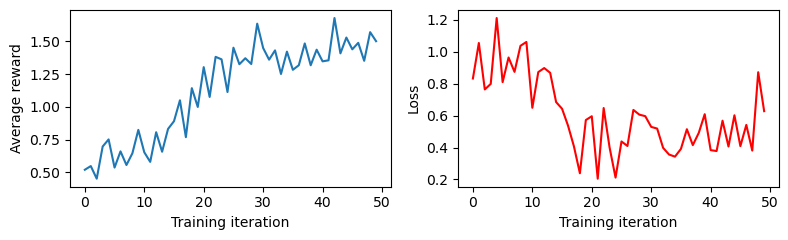

100%|██████████| 100/100 [00:03<00:00, 33.21it/s]


Sample trajectories: 100
[5.974, 5.488, 4.880, 0.046, 0.018, 0.014]    COC1=CC=C(C=C1)S(=O)(=O)N(C2=CC=CC=C2)CC(=O)N(CC3=CC=C(F)C=C3)C(CC4=CC=CC=C4)C(=O)NC5CCCCC5
[5.839, 5.898, 5.680, 0.035, 0.040, 0.069]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(C)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC=C3C(=C2)OCCO3
[5.048, 5.161, 5.852, 0.007, 0.009, 0.096]    O=CC=CCOC(=O)C1=CC=C(C=C1)C(=O)[N+1](=O)N[NH1]C2=CC=CC=C2
[7.766, 8.004, 7.841, 0.994, 1.320, 1.852]    CCNC(=O)C(C)N(CC1=CC=C(C)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.080, 7.704, 6.572, 1.432, 0.917, 0.354]    NCCC1CCN(C1=O)C2=CC=C3C(=C2)C(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[5.148, 5.091, 5.210, 0.009, 0.008, 0.027]    CC=CC(N1CCOCC1)=C(C)SC(S(=O)(=O)N2CCOCC2)=CC(=O)NC3=CC=C(OC)C=C3OC
[5.644, 5.927, 5.482, 0.024, 0.042, 0.047]    COC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3SC(=S)N(C3=O)C4=CC=C(Cl)C(Cl)=C4
[7.501, 7.761, 6.930, 0.694, 0.988, 0.626]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC=C(C)C=C3
[4.971, 4.68

[5.596, 5.470, 5.694, 0.022, 0.017, 0.071]    O=C(NC1=CC=C(Br)C=C1F)CS(=O)(=O)C2=CN(C3=CC=CC=C23)CC(=O)N4CCOCC4
[7.402, 7.277, 7.483, 0.600, 0.495, 1.289]    CCOC=CCCNCC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4
[7.378, 8.525, 7.199, 0.579, 2.172, 0.912]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(C)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[5.976, 5.765, 5.782, 0.046, 0.031, 0.084]    CCCCSCC=CC=CC1C2=NN=C(C3=CC=CC=C3)N2C(O)=C4C=CC=CC4(CC1)C
[7.711, 8.273, 7.210, 0.927, 1.739, 0.925]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(O)C(Cl)=C5
[5.823, 5.391, 5.184, 0.034, 0.015, 0.026]    O=C(NC1=CC(Cl)=CC=C1OC2=CC=CC=C2)CCCCOC=CC=CCC=CN3CCN(CC3)CC4=CC=CC=C4
[6.488, 6.919, 6.451, 0.124, 0.272, 0.288]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=CC=C2C)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[5.808, 5.181, 5.393, 0.033, 0.010, 0.039]    O=C(C(OC)C=CCl)NC1=CC=C(C(Cl)=C1)N2CCC(CC2)C(O)=O
[5.432, 4.541, 5.149, 0.016, 0.003, 0.024]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=CC=C

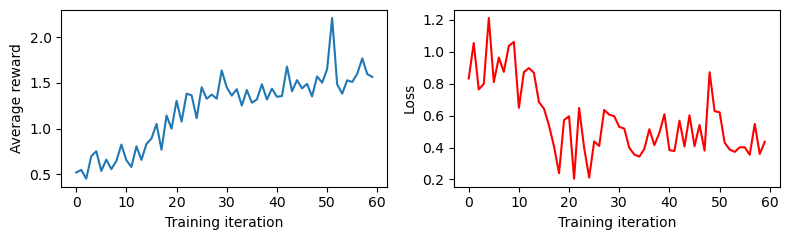

100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


Sample trajectories: 100
[6.427, 6.028, 5.703, 0.111, 0.051, 0.072]    C1COC=CCC1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[5.605, 5.648, 5.553, 0.022, 0.024, 0.054]    CC1CN(CC(C)O1)C(=O)NCCC=C(C2C3=CC=CC=N3)C=CC=C2S(=O)(=O)C4=CC=C(Cl)C=C4
[4.856, 5.324, 4.809, 0.005, 0.013, 0.012]    O=C(C(=O)N1C23)NC=CC(C=C2Cl)=CC=C1C(=O)C4=CC=CC=C4C3=O
[7.576, 8.033, 7.445, 0.772, 1.362, 1.234]    CCCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.009, 5.927, 5.418, 0.049, 0.042, 0.041]    CCCC1=C(C(=O)OCC)C(C2=CC(Cl)=CC=C2OC)N3C(=N1)SC(C3=O)=CC4=CC=C(Cl)C=C4Cl
[6.684, 7.391, 6.985, 0.179, 0.590, 0.678]    CCC(C(=O)NCC(C)C)N(CC1=CC=CC(C)=C1)C(=O)CN(S(C)(=O)=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4
[6.568, 7.397, 6.289, 0.144, 0.596, 0.216]    CCN(CC)S(=O)(=O)C1=CC=C(C=C1)C(=O)CCOCCCN(CC2=CC=CC=C2)C=C3N=C(C(Br)C=C3OC4C5=CC=C(C=C5)[N+1](=O)[O-1])C4=O
[6.125, 5.744, 5.394, 0.062, 0.029, 0.039]    C1COC=CC1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[6

[5.262, 4.953, 4.742, 0.011, 0.006, 0.011]    COC=CC=CC=CSCC1=CC=CC=C1C2=CC=C(C=C2)NC(=O)C3=CC(=NC4=CC=CC=C34)C5=CC=C(Cl)C(Cl)=C5
[4.610, 4.061, 4.866, 0.003, 0.001, 0.014]    C=1COC2=CC=CC=C2N=1
[6.972, 7.199, 6.619, 0.298, 0.437, 0.383]    CCC(C(=O)NC(C)C)N(CC1=CC=C(Cl)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[7.577, 7.226, 6.356, 0.773, 0.456, 0.244]    CN(CCC1=CC=CC=C1)C(=O)C=CC(N2CCN(CC2)CC3=CC=CC=C3)(NCC4=CC=C(C=C4)S(=O)(=O)N5CCOCC5)C6=CC(=CC=C6OC)NC(=O)C7=CC=CC=C7
[7.561, 7.899, 7.252, 0.756, 1.170, 0.977]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[7.576, 8.033, 7.445, 0.772, 1.362, 1.234]    CCCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[7.830, 8.788, 8.030, 1.076, 2.650, 2.180]    CCOC=CC(C=CS(=O)(=O)N(C)C)C=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4
[4.754, 4.609, 5.257, 0.004, 0.003, 0.030]    O=C(C(=O)N=CO)C1=CC=C2C(=C1)C(=O)N(C2=O)CC3=CC=C(Br)C=C3
[5.769, 6.283, 5.532, 0.031, 0.084,

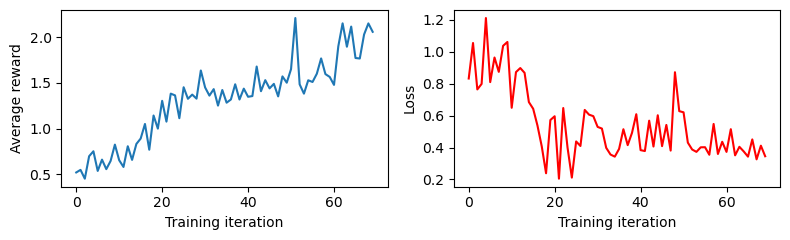

100%|██████████| 100/100 [00:03<00:00, 32.34it/s]


Sample trajectories: 100
[4.822, 4.508, 5.182, 0.005, 0.003, 0.026]    O=CCCNCCCCCNCC=C(C1=CC=CC=C12)N(CC3=CC=CC=C3Cl)N=C2C4=CC=CC=C4
[8.450, 8.729, 7.320, 2.040, 2.540, 1.064]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[6.928, 8.054, 6.868, 0.276, 1.393, 0.570]    COC1=CC=CC=C1NS(=O)(=O)C2=CC=C(C=C2)NC(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[7.413, 8.466, 7.369, 0.610, 2.067, 1.129]    CCNC(=O)C(CC)N(CC1=CC=C(OC)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[5.308, 4.796, 5.652, 0.012, 0.004, 0.065]    CCCNC(C1=CC=CC(O)=C1)C=NN(CC2=CC=CC=C2)C(=O)N
[5.902, 5.289, 5.842, 0.040, 0.012, 0.094]    OCCC=NNCCCNCC=CCOC=CC=C[NH1]CNC(=O)C1=CC=CC=C1Cl
[5.347, 4.941, 5.137, 0.013, 0.006, 0.024]    O=C(NC1=CC=C(C=C1)CC2=CC=NC=C2)C3=CC=CC(=C3)CCC(=O)N4CCN(CC4)C(C5=CC=CC=C5)C6=CC=CC=C6
[6.903, 6.553, 6.748, 0.264, 0.140, 0.473]    CCOC=CC(C(OC)=C)C=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4
[4.676, 4.542, 4.406, 0.004, 0.003, 0.006]    

[7.561, 7.899, 7.252, 0.756, 1.170, 0.977]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[7.787, 8.331, 7.698, 1.021, 1.835, 1.617]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.926, 7.677, 6.947, 0.276, 0.885, 0.641]    CCC(C(=O)NC(C)(C)C)N(CC1=CC=C(C)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC=C(C)C=C3
[6.615, 6.994, 6.329, 0.157, 0.310, 0.232]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(C)C=C2)C(=O)CN(S(C)(=O)=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[7.165, 7.247, 6.986, 0.413, 0.472, 0.679]    CCC(C)NC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[5.890, 5.444, 4.974, 0.039, 0.016, 0.017]    CCOC(=O)CNC(=O)C(C1=CC=C(F)C=C1)N(C2=CC=C(C)C=C2)C(=O)C=CC=3C=C(C)N(C=3C)C4=CC=C(C=C4)N5CCOCC5
[5.607, 5.302, 5.033, 0.022, 0.012, 0.019]    O=CC=CSCNC1=CC=C(C=C1)N(CC)S(=O)(=O)C2=CC=C(Cl)C=C2
[6.056, 6.478, 5.870, 0.054, 0.122, 0.099]    CCOC1=CC(=CC=C1OCC(=O)NC2=CC=CC=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)O

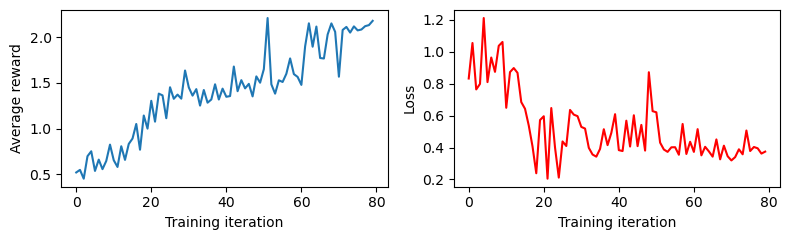

100%|██████████| 100/100 [00:02<00:00, 33.57it/s]


Sample trajectories: 100
[4.564, 4.173, 5.025, 0.003, 0.001, 0.019]    C1COC=CCC1=CCCl
[7.220, 7.336, 6.522, 0.452, 0.543, 0.325]    CCOC1=CC=C(C=C1)N(S(=O)(=O)C2=CC=C(Cl)C=C2)CC(=O)NCCSCC3=CC=C(Cl)C(Cl)=C3
[6.169, 5.642, 5.165, 0.067, 0.024, 0.025]    COC1=CC=C(C=C1)CC(=O)NCC2CC(=O)NC(C2=O)CCC(=O)N(C)C(CC3=CC=CC=C3)C(=O)COC(C)=O
[9.117, 8.735, 7.049, 3.273, 2.551, 0.743]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=C(Cl)C(Cl)=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.008, 6.963, 6.626, 0.317, 0.294, 0.388]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=CC=C3Cl
[5.373, 5.244, 5.461, 0.014, 0.011, 0.045]    O=C(NC1=CC=C(C=C1)N2CCOCC2)CN3C(=O)SC(C3=O)=CC4=CC=C(C=C4)OC5=CC=C([N+1](=O)[O-1])C=C5[N+1](=O)[O-1]
[8.450, 8.729, 7.320, 2.040, 2.540, 1.064]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[5.039, 5.694, 5.491, 0.007, 0.027, 0.048]    CNC(=O)C(C)N(CC1=CC=C(Br)C=C1)C(=O)CN(C)S(=O)(=O)C2=CC=C(Cl)C=C2
[6.284, 6.000, 5.855, 0

[6.242, 5.965, 5.238, 0.078, 0.045, 0.029]    CCOC1=CC=C(C=C1)C2C(C(=O)NC3=CC=CC=C3)=C(C)N=C4SC(C(=O)N42)=CC5=CC=C(O5)SC6=NC(C)=CC(O)=N6
[4.623, 4.275, 4.670, 0.003, 0.002, 0.009]    C1COC=CCC1C=C2C(=N)N3N=C(SC3=NC2=O)CC(=O)N
[6.907, 7.196, 6.675, 0.266, 0.435, 0.420]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC=C5Cl
[7.038, 6.990, 6.248, 0.334, 0.308, 0.201]    COC1=CC=C(C=C1C)S(=O)(=O)NC(CC2=CC=CC=C2)C(=O)NC(C)C3=CC(C(C)C)=C(OC)C=C3C(C)C
[3.692, 3.354, 3.848, 0.000, 0.000, 0.002]    O=CNCON
[4.166, 3.755, 4.818, 0.001, 0.001, 0.013]    NN1CCN(CC1)C2=CC=CC(=C2)C(F)(F)F
[7.724, 7.494, 6.668, 0.943, 0.687, 0.415]    COC1=CC=C(C=C1Cl)NC(=O)CSC=NN=CN(C2=CC=CC=C2)C(=O)C3=CC=C(OC)C(=C3)OCCCN4C=C(N=N4)CCCNC=CC=CC=CC=CC
[7.421, 6.208, 5.695, 0.618, 0.073, 0.071]    CCOC=C1C(C(C)=NN1C2=CC=CC=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.206, 6.655, 6.795, 0.442, 0.169, 0.509]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)N3CCN(CC3)

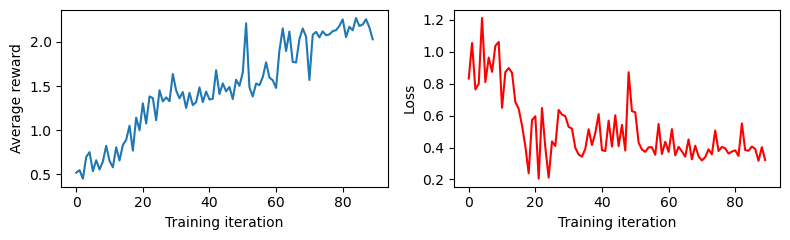

100%|██████████| 100/100 [00:03<00:00, 32.80it/s]


Sample trajectories: 100
[6.644, 6.728, 6.839, 0.166, 0.194, 0.545]    CCCCNC(=O)C(C)N(CC1=CC=C(C)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[7.330, 8.107, 6.900, 0.538, 1.475, 0.598]    COC1=CC=C(C=C1)C(=O)CC=CN=CCC(OC)C(O)=C([N+1]2=CC=CC=C2)C(C)(C)NC3=CC=CC(OC)=C3CC4=CC=CC(=N4)CNN=C(O)C(C)C(=C)OC(=O)C=NC5=CC=C(Br)C=C5
[7.049, 7.205, 6.969, 0.341, 0.441, 0.663]    CCC(C(=O)NC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[7.691, 7.996, 6.526, 0.903, 1.307, 0.327]    CCOC1=CC(Br)=C(C=C1OC)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[8.318, 9.129, 7.220, 1.814, 3.296, 0.937]    CCOC1=CC(=CC=C1OCC2=CC=CC3=CC=CC=C23)C=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C=C5)C67CC8CC(C6)CC(C8)C7
[8.574, 8.984, 7.587, 2.259, 3.019, 1.443]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5
[5.453, 4.595, 5.812, 0.017, 0.003, 0.089]    O=CCOCCNC=CC(N)OC1=CC=C(C=C1C)C2=CC=CC=C2
[3.296, 2.691, 3.281, 0.000, 0.000, 0.001]    CCOC=CC=N
[6.128

[5.685, 5.406, 5.976, 0.026, 0.015, 0.121]    CC1=CC=C(C=C1)NNCCC2=CC=CC=C2NCCC=C(C(=O)N3CCCCC3)C4=CC=C(C(OC)=C4)CC5=NN=CSCCOC(C)(C)C5
[5.790, 5.694, 5.773, 0.032, 0.027, 0.082]    CCN1CCC(CC1)C(O)=CC2=CC(=CC=C2)OCCOC=CC(C=C)C3=CC=CC=C3
[8.483, 9.246, 7.488, 2.097, 3.522, 1.295]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=S)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[5.663, 5.159, 5.989, 0.025, 0.009, 0.124]    N#CCOC(O)=CC=CCl
[6.451, 5.398, 5.705, 0.116, 0.015, 0.072]    O=C(CC1=CC=CC=C1)NOC=CC=C2C=CC=CC2C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[3.655, 3.162, 3.981, 0.000, 0.000, 0.002]    O=C(CC1=CC=C2C(OC)=C1)CC=CO2
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[8.547, 8.299, 7.217, 2.211, 1.782, 0.933]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC3=CC=CC=C23)C=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C=C5)C67CC8CC(C6)CC(C8)C7
[5.748, 6.222, 5.837, 0.030, 0.075, 0.093]    CCCN1C(=O)C(SC1=S)=CC2=CC=C(C=C2)OC(=O)COC3=CC=C(C=C3)S(=O)(=O

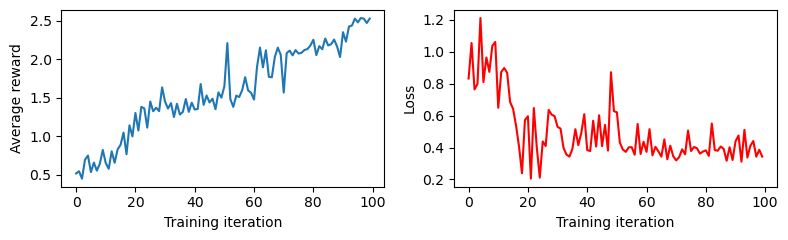

100%|██████████| 100/100 [00:03<00:00, 33.29it/s]


Sample trajectories: 100
[5.401, 5.506, 5.635, 0.015, 0.018, 0.063]    CN1C(=S)N(C2=CC=CC=C2)C(=O)C1=CC3=CC(Br)=C(C(Br)=C3)OCC4=CC=CC(=C4)[N+1](=O)[O-1]
[8.476, 8.478, 6.836, 2.085, 2.088, 0.543]    CCOC1=CC(=CC(Br)=C1OCC2=CC=C(F)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[6.705, 7.021, 6.555, 0.185, 0.325, 0.344]    CCOC=CC(C(=O)C1=CC=CO1)CCCCCCOC2=CC=C(Br)C=C2C=C3NC(=O)N(C3=O)CC4=CC=C(Br)C=C4
[7.981, 7.769, 5.905, 1.286, 0.997, 0.106]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(OC)C(Cl)=C5
[7.378, 8.525, 7.199, 0.579, 2.172, 0.912]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(C)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.387, 5.341, 5.666, 0.103, 0.013, 0.067]    COC1=CC=C(C=C1)CNC=CSCNC(CC2=CC=CC=C2)C(=O)NCC3=CC=CO3
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[8.045, 7.703, 7.267, 1.380, 0.917, 0.995]    CCOC=CCNCCCOCC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C34

[5.871, 5.122, 4.719, 0.038, 0.009, 0.010]    O=CCC1CC1C2=CC=C(C=C2)CN(S(C)(=O)=O)C3=CC=C(Cl)C(=C3)C(F)(F)F
[5.873, 5.898, 5.357, 0.038, 0.040, 0.037]    CC1=CC(Br)=CC=C1NC(=O)CSC=NN=C(C2=CC=C(Br)C=C2)C=C(C)C3=NC4=CC=CC=C4S3
[7.073, 5.954, 5.942, 0.355, 0.044, 0.114]    C1COC=CCNC1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[4.875, 4.594, 5.052, 0.005, 0.003, 0.020]    CCOC=CCCCSC=CC=CC=C1NC(=O)N(C1=O)CC2=CC=C(Cl)C=C2Cl
[6.618, 5.572, 5.355, 0.158, 0.021, 0.037]    C12CC1OC(=O)C(C3=CC=CC=C32)C45CC6CC(C4)CC(C6)C5
[7.405, 7.537, 7.120, 0.602, 0.731, 0.821]    CCOC=CCC=CCSCC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4
[6.709, 5.564, 5.696, 0.187, 0.021, 0.071]    S=CNC(C1=CC=CC=N1)CCNN=NC=CC2=CC=C(O2)C3=CC=CC(Cl)=C3Cl
[6.077, 5.339, 5.899, 0.056, 0.013, 0.105]    C1CCN2CC3C(CC2)(N3C4=CC=C(F)C=C4)C(=O)N1CC(CC)NC(=O)CCC=CC=CC5=CC(=O)NC6=CC=CC=C65
[6.486, 6.057, 5.851, 0.124, 0.054, 0.096]    CCNC(=O)C(CC1=C[NH1]C2=CC=C3C=C12)NC(=O)C(C(C)C)NC(=O)CCCC4C5CC(CN4C=O)CN(C5)C

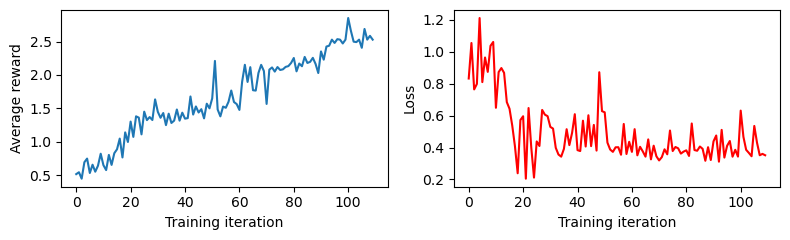

100%|██████████| 100/100 [00:03<00:00, 32.44it/s]


Sample trajectories: 100
[6.221, 6.687, 6.245, 0.075, 0.180, 0.200]    O=C(CC1=CC=CC=C12)NC(C3=CC=CC=C3C2=O)C(=O)NC4=CC=C(C=C4)S(=O)(=O)N5CCCCC5
[6.455, 6.467, 6.489, 0.117, 0.119, 0.307]    CCOC1=CC(=CC(OCC)=C1OCC)C(=O)NC(=S)NC2=CC=C3OC(=NC3=C2)C4=CC=C(Cl)S4
[8.875, 9.433, 7.610, 2.811, 3.887, 1.479]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.676, 8.487, 6.839, 0.884, 2.104, 0.545]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.283, 8.772, 7.647, 0.500, 2.620, 1.536]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)N(C4=CC=CC=C4C)C(=O)N(C3=O)C5=CC=C(Cl)C=C5
[5.928, 5.507, 5.678, 0.042, 0.018, 0.069]    C1CCCCCSCN=CN(C2=CC=CC=C2F)C(=O)N1C3=CC=CC4=CC=CC=C34
[5.823, 5.751, 5.398, 0.034, 0.030, 0.040]    O=C(COC)C(F)=CC1=C(N=C2C=CC=CN2C1=O)N3CCN(CC3)C4=CC=C(F)C=C4
[6.111, 6.593, 6.014, 0.060, 0.151, 0.130]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(C)C=C2)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3C)[N+1](=O)[O-1]
[7.017, 8.0

[6.362, 5.341, 6.601, 0.098, 0.013, 0.372]    C1CCC2CC1(CC=C2C3)CC(N4CC5=CC=C6C(=C5)OCO6)C7=CC=CC=C7C43C(N)=O
[4.624, 4.268, 4.761, 0.003, 0.002, 0.011]    C1NCNCC=NN=CSCC(=O)C1N2CCN(CC2)CC3=CC=CC=C3
[7.108, 7.566, 7.060, 0.376, 0.761, 0.755]    CCCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[7.174, 8.139, 6.766, 0.419, 1.524, 0.487]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC=C5Br
[6.312, 6.028, 6.833, 0.089, 0.051, 0.540]    CC1=CC=C(Cl)C=C1N(S(=O)(=O)C2=CC=CC=C2)CC3=CC=C(C=C3)C(=O)NCC4=CC=CC(=C4)N5CCCC5=O
[4.556, 5.045, 4.531, 0.003, 0.007, 0.007]    COCCCN1C(=O)C(SC1=S)=CC2=CC3=C(C=C2)C(=O)NN=CC(=CC4=CC=CC=C45)N=NN=C5C3
[7.561, 7.899, 7.252, 0.756, 1.170, 0.977]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.426, 5.940, 5.897, 0.110, 0.043, 0.104]    C1COC=CCC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[6.398, 6.990, 6.424, 0.105, 0.308, 0.275]    CCC(C

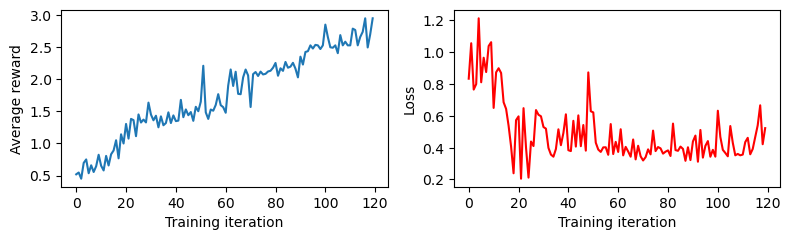

100%|██████████| 100/100 [00:03<00:00, 32.02it/s]


Sample trajectories: 100
[7.472, 8.349, 7.140, 0.666, 1.867, 0.843]    CC=1[NH1]C2=CC=CC=C2C=1CC(=O)OC3=C(Br)C=C(Br)C=C3C=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C=C5)C67CC8CC(C6)CC(C8)C7
[7.359, 7.011, 6.321, 0.562, 0.319, 0.229]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[4.009, 4.063, 4.242, 0.001, 0.001, 0.004]    CN(S(C)(=O)=O)C1=CC=C(C=C1)OCC(=O)NC2=CC=C(C=C2)S(=O)(=O)N3CCOCC3
[7.965, 8.159, 6.970, 1.263, 1.555, 0.664]    CCOC1=CC(=CC=C1OCC(=O)NC2=CC=C(F)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.000, 7.264, 6.881, 0.313, 0.485, 0.581]    CCOC=CCCC1=CC=NC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[8.875, 9.433, 7.610, 2.811, 3.887, 1.479]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[5.910, 5.167, 5.189, 0.041, 0.009, 0.026]    C1COC=CC(CCC(C)C)=C(Br)C=C1OCC2=CC=C(Br)C=C2F
[5.609, 5.229, 4.692, 0.023, 0.011, 0.010]    COC1=CC=C(C=C1)CNC(=O)C(CC2=CC=CC=C2)N(CC3=C

[8.875, 9.433, 7.610, 2.811, 3.887, 1.479]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[5.883, 6.448, 5.432, 0.039, 0.115, 0.043]    COC1=CC=C(C=C1)OCC2=NN=C(C=C2)SCCCNC(=S)NC(=O)C3=CC=C4C(=C3)C(=O)N(C4=O)C5=CC=C(C=C5)C67CC8CC(C6)CC(C8)C7
[8.925, 9.613, 7.785, 2.907, 4.240, 1.759]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C56CC7CC(C5)CC(C7)C6
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[5.009, 4.760, 4.922, 0.007, 0.004, 0.016]    O=CNCCSC1=NN=C(O1)C2=CC=CC(=N2)[N+1](=O)[O-1]
[5.648, 5.896, 5.502, 0.024, 0.040, 0.049]    CCOC=CC(C1=CC(Cl)=CC2=C1OC)=C(Br)C=C2C=C3C(=O)NC(=S)NC3=O
[7.214, 7.804, 6.954, 0.447, 1.043, 0.648]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC(=CC=C5O)[N

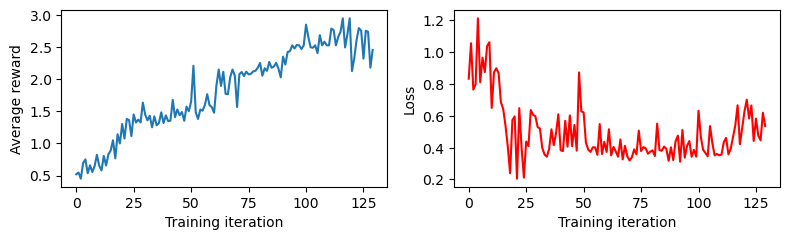

100%|██████████| 100/100 [00:02<00:00, 35.58it/s]


Sample trajectories: 100
[4.906, 4.571, 4.907, 0.006, 0.003, 0.015]    O=C(CC=C1OCC(=O)N2C3=CC=CC(C)=C3)CSC=NC(C4=CC=CC=C4)=C2C1S
[8.622, 7.586, 7.129, 2.345, 0.783, 0.830]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C(Cl)=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[8.004, 7.114, 6.267, 1.319, 0.380, 0.208]    CCOC1=CC(=CC(Br)=C1OCC)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[5.988, 5.704, 5.695, 0.047, 0.027, 0.071]    CC1=CC=CC=C1NC(=O)CN2C(=O)SC(C2=O)=CC3=CN(C4=CC=C(Br)C=C34)CC5=CC=C(Cl)C=C5Cl
[7.757, 8.037, 7.527, 0.983, 1.368, 1.352]    O=C(C=O)C1=CC=C2C(=C1)C(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[5.064, 4.845, 5.234, 0.008, 0.005, 0.029]    O=CSCSC=CC1=CC(Br)=CC=C1OCC2=CC=CC3=CC=CC=C23
[8.875, 9.433, 7.610, 2.811, 3.887, 1.479]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[5.010, 4.958, 4.865, 0.007, 0.006, 0.014]    COC(=O)CC([O-1])C1=C2C=C(C=C1)OC3=CC=C(C=C3)C=CC4=CC(Br)=CC=C4OCC(O)C2=O
[6.444, 5.581, 5.599, 0.1

[6.258, 6.989, 6.520, 0.080, 0.307, 0.324]    CCC(C(=O)NCC(C)C)N(CC1=CC=CC=C1)C(=O)CN(S(C)(=O)=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4
[6.102, 5.999, 6.649, 0.059, 0.048, 0.403]    C1C2CC(C=CC2=C1)C=C(C3=CC=CC=C3)C=CCCN=NNN=CC4=CC=C(Br)S4
[8.991, 9.422, 8.036, 3.032, 3.864, 2.190]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[5.028, 5.185, 5.179, 0.007, 0.010, 0.026]    CCOC=CCCNC=CC1=CC=C1OCC
[6.611, 6.733, 5.570, 0.156, 0.195, 0.056]    CC1OC=CC(=C1OCC2=CC=C(Cl)C=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[6.246, 5.306, 4.976, 0.078, 0.012, 0.017]    O=C1NN(C2=CC=CC=C2)C(=O)C1=CC3=CC=C(S3)SC4=CC=C(C=C4)N5C(=O)C6CC7=CC=CC=C7C(C68C5=O)C9=CC=CC=C9CC8
[8.554, 8.821, 7.420, 2.223, 2.710, 1.199]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(Cl)=C4)C56CC7CC(C5)CC(C7)C6
[6.733, 7.443, 6.32

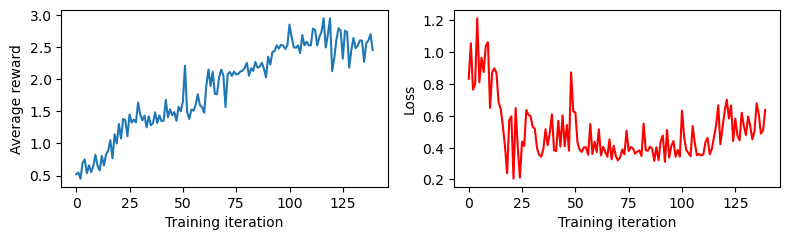

100%|██████████| 100/100 [00:03<00:00, 32.26it/s]


Sample trajectories: 100
[7.077, 6.070, 5.647, 0.357, 0.056, 0.065]    C1COC=CC(=N1)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5O
[5.837, 6.023, 5.299, 0.035, 0.051, 0.033]    CCOC(=O)C1=C(C(F)(F)F)N=C2SC(C(=O)N2C1C3=CC=C(Cl)C=C3)=CC=C4C=C(CC(OC)=C4OC)OCC5=CC=C(Cl)C(Cl)=C5
[7.054, 7.033, 6.702, 0.344, 0.332, 0.439]    CCOC(=O)C1=CC=C(C=C1Cl)NC(=O)CN(C2=CC=CC(Cl)=C2Cl)S(=O)(=O)C3=CC=C(C)C=C3
[7.169, 8.625, 6.837, 0.416, 2.350, 0.543]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCC=6C(C5)=NOC=6[N+1](=O)[O-1]
[6.099, 5.478, 4.945, 0.059, 0.017, 0.016]    C1COC=CC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5C
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[6.861, 6.103, 6.513, 0.246, 0.059, 0.320]    CCC=CC1=CCC(C(F)F)=CC(Br)=C1OCC2=CC=C(C=C2)[N+1](=O)[O-1]
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC

[6.292, 5.597, 5.353, 0.085, 0.022, 0.036]    CC1=C(C(=O)NC2=CC=CC=C2)C(C3=CC=CS3)N4C(=N1)SC(C4=O)=CC5=CC=C(O5)C6=CC=CC(=C6C)[N+1](=O)[O-1]
[8.354, 8.312, 7.164, 1.875, 1.804, 0.871]    CCC=NNC(=O)C=C(C)C=C(C1=CC=C(Br)C=C1)C=CC(C2=CC=CC=C2)C=NC=NN=C=NC3=CC=C4C(=C3)C(=O)N(C4=O)C5=CC=C(C=C5)C67CC8CC(C6)CC(C8)C79OC(=O)C%10=CC=CC=C%109
[6.555, 5.872, 6.081, 0.141, 0.038, 0.148]    CCC(C1CCCCC1)C(=O)NC2C=CN=COC3=CC=C(C=C3)C=CC4=CC(N)=CC=C4C2
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[6.036, 5.380, 4.819, 0.052, 0.014, 0.013]    O=CCC=NNC1=CC=C2C(=C1)C(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5C
[6.299, 6.917, 5.678, 0.087, 0.271, 0.069]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56C7C8CC(C5)CC(C8)C6CCC7
[7.049, 6.047, 5.338, 0.341, 0.053, 0.035]    C1COC=CC(CC2=CC=CC=C21)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[8.503, 9.054, 7.402, 2.132, 3.152, 1.174]    CCOC1

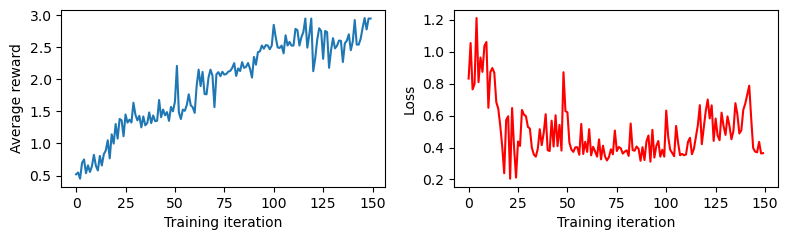

100%|██████████| 100/100 [00:03<00:00, 25.64it/s]


Sample trajectories: 100
[9.327, 9.676, 7.754, 3.680, 4.364, 1.709]    CCOC1=CC(=C(Br)C=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6O
[3.434, 2.832, 3.430, 0.000, 0.000, 0.001]    N1C(C)=N1
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[6.177, 7.086, 6.380, 0.069, 0.363, 0.254]    S=C(NCC1(CCCC1)C2=CC=C(Cl)C=C2)C(Br)(Br)Br
[7.388, 6.706, 6.487, 0.587, 0.186, 0.307]    CCOC=CCNCCCSC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4O
[4.834, 4.452, 5.304, 0.005, 0.002, 0.033]    O=CNC=CC=CCCN1C(=O)SC(C1=O)=CC2=CN(C3=CC=CC=C23)CC(=O)N4CCCCCC4
[5.556, 5.682, 5.231, 0.020, 0.026, 0.029]    O=C(C=CCl)N1C=CC(C=C1Cl)C2=NC3=CC=CC=C3N=C2NS(=O)(=O)C4=CC=C(Cl)S4
[6.951, 7.340, 6.497, 0.288, 0.546, 0.312]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C35)C=CC=C(C(O)=O)C(Cl)=C5Cl
[4.477, 4.145, 4.609, 0.002, 0.001, 0.008]    S12CCNC(=O)CCCCN1C(=O)NC2C3=CC(=CC=C3C)S(

[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[5.782, 6.387, 5.897, 0.032, 0.102, 0.104]    O=C(CC1=CC(Cl)=CC=C1)C2=CC=C(C=C2)NS(=O)(=O)C3=CC=C(Cl)S3
[9.232, 9.862, 7.644, 3.496, 4.732, 1.531]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6O
[6.788, 6.818, 6.257, 0.216, 0.228, 0.204]    COC(=O)[NH1]C=CC(CC(=O)OC)(CC1=C(Cl)C=CC2=C1Cl)OC3=CC=CC=C23
[8.826, 8.040, 7.363, 2.721, 1.372, 1.121]    CCOC=CC(C1=CC=C(C)C(Cl)=C1)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5O
[4.520, 4.484, 4.555, 0.003, 0.002, 0.007]    O=C(O)CCCOCNC(=O)C=1C=C([NH1]N=1)C2=CC=CC(=C2)C(F)(F)F
[8.449, 8.464, 6.728, 2.038, 2.063, 0.458]    CCOC1=CC(=CS1)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5O
[8.297, 8.328, 6.983, 1.779, 1.831, 0.676]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6
[9.232, 9.862, 7.644, 3.496, 4.732, 1.531]   

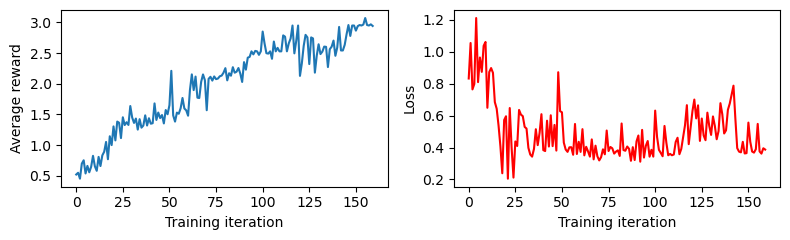

100%|██████████| 100/100 [00:03<00:00, 26.36it/s]


Sample trajectories: 100
[9.158, 9.740, 7.747, 3.352, 4.490, 1.696]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5C6CCC(C5)(CC6)C7=CC=CC=C7
[8.182, 7.416, 6.372, 1.592, 0.612, 0.250]    CCOC1=CC(C(C)=C1Cl)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5CC7=CC=NC=C7O
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[9.306, 9.290, 7.474, 3.640, 3.608, 1.275]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)(C6)CC8=CC=C(Br)C=C8Cl
[5.587, 5.969, 6.281, 0.022, 0.046, 0.213]    O=C(CCl)CSC1=CC=C(C=N1)S(=O)(=O)NC2=CC=C(F)C=C2
[4.540, 4.254, 4.624, 0.003, 0.002, 0.009]    O=CCCCCCCCCCCNC(=O)NC1=NC(=CS1)C2=CC=C(C=C2)[N+1](=O)[O-1]
[7.907, 7.141, 6.475, 1.181, 0.397, 0.300]    CCOC=CCOCCCNC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2Br)C3C4C5CC6(C3)CC(C57)(C(C)C6C4O)C(O)C78OCN[NH1]C(O)=C8
[7.600, 6.667, 6.082, 0.798, 0.173, 0.148]    CCOC1=CC(=CC(Br)=C1OCC2=CC

[8.520, 9.246, 7.302, 2.163, 3.523, 1.040]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)C6=CC=CC=C6Cl
[5.889, 6.460, 6.439, 0.039, 0.118, 0.282]    C1OC2=CC=C(C(OC)=C2)C=NN=CN1SCC(=O)NC=CC(Cl)=C(Br)SC(O)=CC(=O)O
[6.764, 6.462, 6.520, 0.206, 0.118, 0.324]    CCOC1=CC(=CC=C1OCC(=O)N2CCOCC2)C3C(=C(C)NC4=NC=NN43)C(=O)NC5=CC=CC(C)=C5C
[7.787, 8.331, 7.698, 1.021, 1.835, 1.617]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.888, 9.661, 7.280, 2.836, 4.336, 1.011]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC8(C5)CC(C7)C68C=C9SC(=S)N(C9=O)CC%10=CC=CC=C%10
[5.969, 5.149, 5.327, 0.046, 0.009, 0.035]    O=CCNCCCC(OC1=CC=C2C=C1)[NH1]N2
[6.687, 7.010, 6.563, 0.179, 0.318, 0.349]    CCC(C(=O)C1=CC=C(Cl)C(Cl)=C1)N(CC2=CC=C(Cl)C=C2)CC3=CC4=CC(C5=CC=CS5)C=C4[NH1]C3=O
[7.447, 7.345, 7.341, 0.641, 0.550, 1.091]    C1COC=CCC1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C4CCCC(C4)CNN=CC=CC(N)=O
[7.159, 8.036, 6.988, 0.

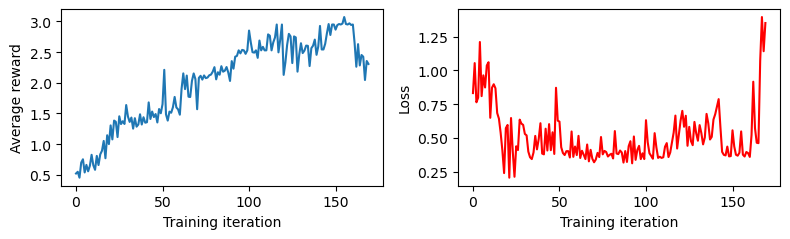

100%|██████████| 100/100 [00:03<00:00, 31.07it/s]


Sample trajectories: 100
[7.139, 7.667, 6.558, 0.396, 0.874, 0.346]    CCOC=CC(C(=O)OC(C)C)=CC=CC=C1C(=O)N(C2=CC=CC=C2)C(=O)N(C1=O)C3=CC=C(C=C3Br)C4=CC=C(C)C=N4
[6.130, 6.157, 5.649, 0.063, 0.066, 0.065]    CCC1=C(C(=O)OC)C(C2=CC=CC=C2)N3C(=N1)SC(C3=O)=CC4=C(C)N(C5=CC=CC=C45)CC6=CC=CC=C6Cl
[7.847, 9.129, 7.229, 1.099, 3.296, 0.948]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56C7CCC(C5)CCOC6C7
[5.358, 5.261, 5.533, 0.014, 0.011, 0.052]    COC(=O)C1=CC(OC)=C(OC)C=C1NC(=O)CN(C2=CC=C(Br)C=C2)S(=O)(=O)C3=CC=CC=C3
[5.676, 4.796, 4.923, 0.026, 0.004, 0.016]    C1COC=CCNN=C=CC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C(Br)=C3)OCC4=CC=CC=C4Cl
[8.724, 8.442, 7.223, 2.530, 2.026, 0.941]    CCOC1=CC(=CC=C1OCC(=O)NC2=CC=C(C)C(C)=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)C=C6Br
[5.659, 4.908, 5.291, 0.025, 0.006, 0.032]    CC1=CC=CC=C1CNNCCOCCOC=CC=CC(CC2=CC=CC=C2)C(=O)NC(C)(C)C
[7.510, 7.298, 6.543, 0.704, 0.511, 0.337]    CC1NC(C(O)C(O)C12O)(NC=3SC4=C(CCCC4)C=3C2=O)SCC(=O)N

[5.351, 5.075, 5.129, 0.013, 0.008, 0.023]    C1COC=CC1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)OCC4=CC=CC=C4Cl
[6.273, 6.443, 7.107, 0.082, 0.114, 0.806]    CCC(C(=O)NCC(C)C)N(CC1=CC=CC(C)=C1)C(=O)CCCN(S(C)(=O)=O)C2=CC(C)=CC=C2C
[8.532, 9.335, 6.582, 2.183, 3.696, 0.360]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)C(=O)N6CCCC6C(=O)NC(C(O)=O)CC7=CC=CC=C7
[6.019, 6.438, 6.083, 0.050, 0.113, 0.148]    CC1=CC=C(Cl)C2=C1N3C(=O)NC(=O)C(C3=O)=CC4=CC(Cl)=CC=C4N2CC5=CC=CC=C5
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[8.328, 8.623, 7.760, 1.832, 2.347, 1.718]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5
[6.950, 8.619, 7.254, 0.288, 2.340, 0.979]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C5=C4)C6CCCC(C6)OC5=O
[7.944, 9.254, 7.325, 1.233, 3.538, 1.070]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56

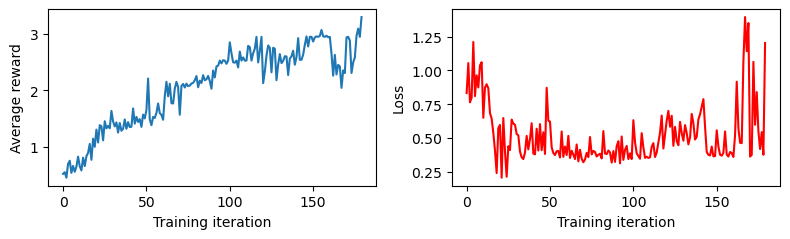

100%|██████████| 100/100 [00:03<00:00, 32.17it/s]


Sample trajectories: 100
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[8.058, 7.378, 6.097, 1.399, 0.578, 0.152]    CCOC1=CCCNCCCCCCCN1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C4CCC5C(C4)N=CN=C5O
[6.248, 6.537, 5.118, 0.079, 0.136, 0.023]    CCOC1=CC(C(=O)N1C2=CC=CC=C2)C=C3C(=N)N4N=C(C5=CC=CN=C5)SC4=NC3=O
[6.344, 5.417, 4.701, 0.095, 0.015, 0.010]    CC1OC=CC(C(Cl)=C1)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C4CCCC(C4)(OC5(CO)C(O)CO)C5=O
[6.016, 5.815, 5.564, 0.050, 0.034, 0.055]    O=CCOC1=CC=CC=CC=CC=C1C=2N=C(C3=CC=C(Br)C=C3)N(N=2)C4=CC=CC(Br)=C4
[5.620, 5.460, 5.610, 0.023, 0.017, 0.060]    COC1=CC=CC=C1CNOCC=C2CCC3=CC=C(C(OC)=C3)C4=CC=CC=C24
[6.167, 5.051, 5.258, 0.067, 0.007, 0.030]    CCOC=CCCC=NC=CNC(=O)C1CC2CC(C1)CC(C2)CC3=CC=C(Cl)S3
[5.605, 6.422, 5.239, 0.022, 0.109, 0.029]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)OCC5=CC=CC=C5Cl
[6.389, 6.756, 6.089, 0.103, 0.204, 0.150]    C

[6.258, 6.403, 6.625, 0.080, 0.106, 0.387]    CNC(=O)C(C)N(CC1=CC=CC(Br)=C1)C(=O)CCCN(S(C)(=O)=O)C2=CC=C(OC)C=C2
[9.100, 9.463, 7.290, 3.239, 3.946, 1.025]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CC7CC(C5)CC(C7)C6O
[6.100, 6.443, 6.554, 0.059, 0.114, 0.344]    CCOC1=CC(=CC(OCC)=C1OCC)C2=NN=C(O2)SC(C(O)=O)=CC3=CC=C(C(OC)=C3)OCC4=CC=C(C)C=C4
[8.735, 9.286, 7.759, 2.551, 3.600, 1.717]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=C4C=C(CC(Br)=C4O)C56CC7CC(C5)CC(C7)C6C8COC=CC(C(C9)=O)C=C8CSC=NC=CC(Cl)(N%10C%11=CC=C%12C(=C%11)OCO%12)C9%10N%13CCN(CC%13)CC%14=CC=CC=C%14
[5.766, 6.294, 5.676, 0.031, 0.086, 0.068]    COC1=CC=C(C=C1)CCN2C(=O)C(SC2=S)=CC3=CC=CC(=C3)OCC(=O)NC4=CC=CC=C4F
[6.751, 6.171, 6.049, 0.202, 0.068, 0.139]    C1COC=CCN1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C4C5C6CC(C4)CC(C6)N5C(C)C
[6.112, 5.250, 5.386, 0.060, 0.011, 0.039]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3SC(=O)N(C3=O)CCN4CCOCC4
[8.328, 8.623, 7.760, 1.832, 2.347, 1.718]    O=C(

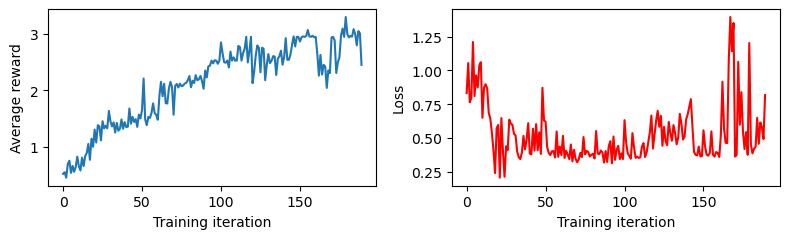

100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Sample trajectories: 100
[7.289, 7.072, 7.208, 0.504, 0.354, 0.923]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)(C=O)CCC
[8.789, 8.853, 7.491, 2.652, 2.770, 1.300]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5Cl
[5.638, 5.204, 5.430, 0.024, 0.010, 0.042]    O=CCSC=NCSC=CNC1=NC(C2=CC=CC=C2)=C(S1)C3=CC=C(C=C3)N(C)C
[7.058, 8.483, 7.190, 0.346, 2.097, 0.901]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(Br)=C4)OCC5=CC=CC=C5Cl
[6.630, 5.706, 6.349, 0.162, 0.027, 0.241]    O=CN=CCN(C1=CC=CC(Cl)=C1Cl)S(=O)(=O)C2=CC=CC=C2
[8.670, 9.240, 7.131, 2.431, 3.511, 0.833]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)=CN=NNCCCN6S(C)(=O)=O
[6.283, 6.513, 5.871, 0.084, 0.130, 0.099]    CCOC=CCCCCSC=CC=CC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C3CCCC(C3)(N4CCN(C)CC4)C=O
[6.849, 6.961, 7.001, 0.240, 0.293, 0.695]    CC=CC=NNNCC1=CC=CC=CC=CC=C1CCOC2=CC=C3C4=C2OCC4(C=CS3)N5C(=O)C6=CC=C(C

[5.749, 5.234, 4.986, 0.030, 0.011, 0.018]    C1OC(=O)CC2C(=O)NC3CN2N1CC3C=C4C(=O)N(N=C4C)C5=CC=C(C=C5)S(N)(=O)=O
[5.532, 5.042, 5.523, 0.019, 0.007, 0.051]    C1CC2=CC=C(C=C2)OCC=NN=CC1SCC(=O)C3=CC=CC(=C3)[N+1](=O)[O-1]
[6.460, 7.721, 7.285, 0.118, 0.938, 1.019]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(Cl)C(=C4)C(F)(F)F
[8.891, 9.293, 7.450, 2.843, 3.613, 1.240]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=C5C=C(C=C4)C6CCCC(C6)N=C(C7=C5NCCCC7)NC(=O)C8=CC=CN=C8C9COCC9
[3.200, 2.713, 3.531, 0.000, 0.000, 0.001]    CC1=CC=C(C=C1)CNF
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[8.440, 9.224, 7.603, 2.021, 3.479, 1.468]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5C6CCC(C5)S6
[5.737, 5.238, 5.434, 0.029, 0.011, 0.043]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC=C(CC4=CC=CO4)C(=C)[N+1](=O)[O-1]
[6.681, 5.751, 6.493, 0.178, 0.030, 0

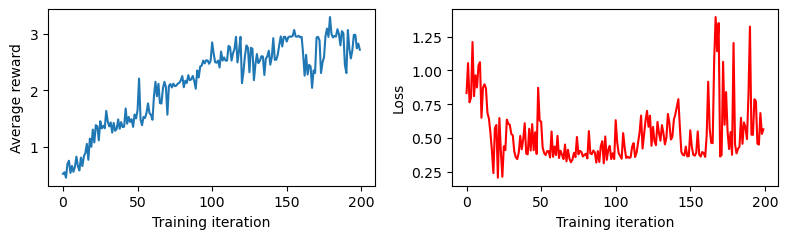

100%|██████████| 100/100 [00:03<00:00, 31.65it/s]


Sample trajectories: 100
[7.393, 7.489, 6.315, 0.592, 0.683, 0.226]    CCOC=CCCNC=NC1=CC=CC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3C)C4CC5CC(C4)NC5=O
[6.358, 6.552, 6.321, 0.097, 0.140, 0.229]    CCOC1=CC(=CC=C1OCC2=CC=CC3=C2F)C=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C=C5)C67CCCC(C6)CC(=C7)CO3
[4.633, 4.279, 5.221, 0.003, 0.002, 0.028]    CCCNC(=O)C(C(C)C)NC(=O)C(CC(=O)NC1CCCC1)CCCN2C(=O)CCNO2
[5.301, 4.998, 5.222, 0.012, 0.007, 0.028]    O=C(N1CCCCC1)CN2C(=O)SC(C2=O)=CC3=CN(C4=CC=CC=C34)CCOC5=CC=C(C)C=C5Br
[7.735, 7.672, 6.832, 0.956, 0.880, 0.539]    CCOC1=CC(=C(C)N1CC2CCCO2)C=C3C(=O)NC(=O)N(C3=O)C4=CC5=C(C=C4)C6CC7CC5(C6)C(=O)C=8SC=CC=87
[5.836, 5.368, 5.648, 0.035, 0.014, 0.065]    O=C(C1=CC=C(N2CCCC=3C2)C(=C14)[N+1](=O)[O-1])NCC=3C[NH1]4
[7.714, 9.002, 6.982, 0.929, 3.052, 0.675]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC5=C(C=C4)C6CCCC(C6)C=C5C(C)C
[5.760, 6.196, 6.140, 0.030, 0.071, 0.165]    C1COC2=CC(N=N2)C=CC(=N)N3C(=N1)SC(C3=O)=CC4=CC=C(O4)C5=CC=C(C=C5C)C(=O)NCCC6=CC=CC=

[6.017, 6.164, 5.644, 0.050, 0.067, 0.064]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC3=CC=CC=C23)C=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C(Br)=C5)OCC(=O)OC
[6.403, 7.486, 7.332, 0.106, 0.680, 1.079]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)N(C4=CC=CC=C4)C(=O)N(C3=O)C5=CC=CC=C5
[6.805, 6.731, 7.518, 0.222, 0.195, 1.340]    CCNCC(=O)NC1CCN(CC(C)C)CCCNCCC1C(=O)CC=CC2=C(C)NCSC=C2F
[6.246, 7.626, 6.554, 0.078, 0.827, 0.343]    CC1=CC=CC=C1N2C(=O)NC(=O)C(C2=O)=CC3=CC=C(C(OC)=C3)OCC4=CC=CC=C4Cl
[5.701, 5.535, 5.692, 0.027, 0.019, 0.071]    CCOC1=CC=CC=C1NC(=O)COC(=O)CCC(=O)NC2=CC=C(C=C2)C(=O)OC(C)C(=O)NCCC3=CC=CC=C3
[6.673, 7.992, 6.203, 0.175, 1.301, 0.185]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)(C(=O)OC(C)C)O
[5.508, 5.403, 6.169, 0.018, 0.015, 0.174]    O=C(C=C1C(=O)NN(C1=O)C2=CC=CC=C2)COC(=O)C3=CC=CC(=C3)C(F)(F)CC(=O)N(C=O)C4=CC=CC=C4F
[6.522, 7.043, 6.093, 0.132, 0.337, 0.151]    CCOC=CC(C=CS(=O)(=O)N1CCCCC1)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C4CCCC(C4)CCC5=CC=CC=C5Cl

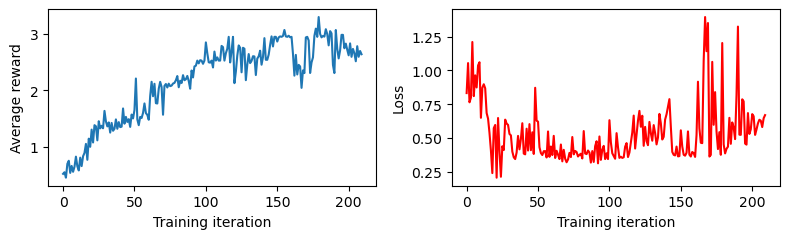

100%|██████████| 100/100 [00:03<00:00, 30.04it/s]


Sample trajectories: 100
[8.371, 9.583, 7.738, 1.904, 4.181, 1.681]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC5=C(C=C4)C6CCCC(C6)CCNC=C(CC7=CC=CC=C75)C(=O)OC(C)(C)C
[8.829, 8.960, 7.744, 2.727, 2.972, 1.691]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C56C7CCC(C5)C6C7O
[8.890, 8.971, 7.769, 2.840, 2.993, 1.733]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4[N+1](=O)[O-1])C56CCCC(C5)C6
[8.759, 9.215, 7.026, 2.596, 3.463, 0.720]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)N6C=CC7=C(C)N=CN=C7O
[9.005, 9.662, 7.439, 3.057, 4.337, 1.226]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)N6C(C)(C)CC(O)=O
[6.558, 6.464, 6.312, 0.142, 0.119, 0.225]    CCOC=CC(=CC1=CC=C(Cl)C(Cl)=C1)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C4=C3)C5CCCC(C5)CCN=C4CCOC
[7.924, 8.853, 7.530, 1.205, 2.771, 1.358]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5C6CCC(C5)N6CCO

[5.593, 5.206, 5.259, 0.022, 0.010, 0.030]    O=C(NC1=CC=C(C=C1)S(=O)(=O)N2CCOC3C2)C=CC=C(NCC4=CC=CO4)C(=C3)[N+1](=O)[O-1]
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[8.926, 9.770, 7.332, 2.908, 4.551, 1.079]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)N6CC7=CC=CC=C7
[5.866, 6.007, 5.955, 0.037, 0.049, 0.117]    CCNC(=O)C(C)N1C(=O)SC(C1=O)=CC2=CC=C(C(OC)=C2)OCC(=O)NC3=CC(C)=CC=C3OC
[9.292, 9.639, 7.078, 3.611, 4.292, 0.774]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)N6C7=CC=C(F)C=C7Cl
[3.950, 3.755, 4.652, 0.001, 0.001, 0.009]    C1(=O)C=C1C(CC)NC(C)=O
[8.892, 9.068, 7.371, 2.844, 3.179, 1.132]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(N=C45)C6CC7CC(C6)CC5C7
[6.182, 7.404, 6.337, 0.069, 0.602, 0.235]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(C)=C2)C(=O)CCCN(S(C)(=O)=O)C3=CC=C(OC)C(Cl)=C3
[6.580, 5.858, 6.460, 0.147,

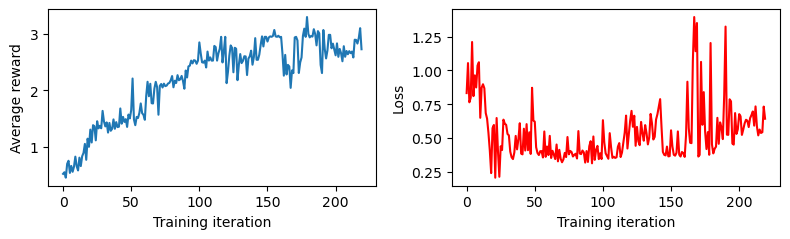

100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Sample trajectories: 100
[4.934, 4.528, 5.302, 0.006, 0.003, 0.033]    C1COC=CC(C2=CC(C)=CC=C2OC)=CC(Cl)=C1OCC(=O)NC3=CC=C(C)C=C3
[6.541, 5.708, 6.047, 0.137, 0.027, 0.139]    O=C(NC1=CC=CC=C1)CN2C(=O)SC(C2=O)=CC3=CN(C4=CC=C(Br)C=C34)CCCOC5=CC=CC=C5Cl
[8.773, 9.227, 7.515, 2.621, 3.486, 1.335]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)(CC6)CCOP(C)O
[5.942, 5.936, 4.739, 0.043, 0.043, 0.011]    CSC1=NN=C(S1)NC(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.800, 7.971, 6.719, 0.220, 1.271, 0.451]    CCOC1=CC(=CC(Br)=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)CCNC(=O)C(C(=O)NCC4=CC=C(OC)C(OC)=C4)CC5=CC=CC=C5
[6.672, 7.783, 6.506, 0.175, 1.016, 0.316]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5=CC=C(CC)C=C5
[7.662, 6.526, 6.193, 0.868, 0.133, 0.182]    CCCOC1=CC=C(C=C1)C(=O)NNC=CC=CN=CC2=CC=C(C=C2)C34CCCC(C3)C4CCCCS(O)(=O)=O
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC

[6.713, 8.140, 6.823, 0.188, 1.525, 0.532]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(=C4)[N+1](=O)[O-1])OCC(=O)NC5=CC=CC(Cl)=C5Cl
[8.590, 9.476, 7.361, 2.288, 3.971, 1.118]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5CCCC(C5)(C(=O)NC6=CC=C(C=C6)OCC7=CC=C8C=C7)CCC8=O
[8.138, 9.254, 7.461, 1.523, 3.538, 1.257]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5CCCC(C5)C6NCCOC(C)C6=O
[7.669, 8.397, 7.726, 0.876, 1.948, 1.662]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[7.017, 8.076, 7.118, 0.323, 1.427, 0.818]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)OCC5=CC=CC=C5Cl
[6.957, 7.180, 7.144, 0.291, 0.423, 0.847]    O=CSC=CC=CCN1C(=O)SC(C1=O)=CC2=C3C=C(O2)C=CC=CCC3C(=O)NC4=CC=C(C=C4)C(N)=O
[8.674, 9.170, 7.076, 2.439, 3.374, 0.772]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC5=C(C=C4)C6CCC7C5(C6)CC(Br)=C7OCC8=CC(C)=CC(C)=C8
[6.903, 7.502, 6.042,

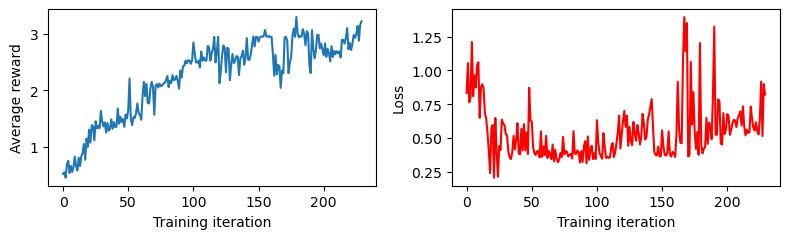

100%|██████████| 100/100 [00:03<00:00, 31.21it/s]


Sample trajectories: 100
[6.023, 5.428, 5.892, 0.051, 0.016, 0.103]    CCC1=NN=C2SC(=NN12)C3=CC=C(Cl)C(=C3)NC(=O)C4=CC(Br)=C(Br)S4
[6.604, 5.803, 5.305, 0.154, 0.033, 0.033]    O=C(CO)NC(NC1=CC=CC=C1Br)CCC(=O)NC(NCCC2=CC=CC=C2)CC3=CC=CC=C3Cl
[4.452, 3.602, 4.230, 0.002, 0.000, 0.004]    CCOC=CCC1=CN=CC=N1
[6.582, 7.530, 6.521, 0.148, 0.723, 0.325]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(OC)=C4)OCC5=C(C)C=C(C)C=C5[N+1](=O)[O-1]
[9.471, 9.678, 7.496, 3.962, 4.368, 1.307]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5CCCC(C5)CNC=C(NC(=O)C6=CC=CO6)CC=C(C)C
[6.853, 6.120, 5.803, 0.242, 0.061, 0.087]    CCOC=CCNC=CC=NNC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)C34CC=5CC(C3)C4(C=5C)CC6=CC=C(C=C6)NC7=CC=CN=C7
[6.164, 7.321, 6.835, 0.067, 0.530, 0.542]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(Br)C(C)=C4C
[6.164, 7.321, 6.835, 0.067, 0.530, 0.542]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(Br)C(C)=C4C
[8.867, 9.

[6.120, 5.152, 5.966, 0.061, 0.009, 0.119]    CCOC=CC=CNC=C1C(=O)NC(=O)N(C1=O)C2=CC=C(F)C=C2Cl
[5.389, 5.093, 5.096, 0.015, 0.008, 0.022]    CCCCOC(=O)C1=CC=C(C=C1)N2CC(CC2=O)C(=O)OCC(=O)NC3=CC(=CC=C3Cl)C(F)(F)F
[6.327, 6.729, 5.543, 0.091, 0.194, 0.053]    CCOC1=CC=C(C=C1OC2)C=CC(=C2)C(=O)NS(=O)(=O)C3=CC=CC(=C3)C(=O)N4CCN(CC45)COC6=CC=CC5=C6
[6.590, 5.479, 5.934, 0.150, 0.017, 0.112]    CCOC=CC=NC1=CC=C(C=C1Br)C(=O)OCC=C2SC(=NC2=C)C3=CC=C(Cl)C=C3
[7.971, 7.742, 6.594, 1.271, 0.965, 0.368]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCC6C(C5)(CC=C6OCC7=CC=C(Br)C=C7)CC(=O)NC(C)(C)C=O
[6.250, 6.231, 5.765, 0.079, 0.076, 0.081]    CCNC(C1=CC=CC2=CC3=CC4=C12)(C(=O)NC3=S)C5=CC=CC=C5C=CC(=C)C(F)C=C4SC6=CC=C(C=C6)C(O)=O
[5.587, 5.206, 5.181, 0.022, 0.010, 0.026]    O=C(NC1=CC=C(C=C1)N2CCOCC2)CN3C(=O)SC(C3=O)=CC4=CC=C(O4)SC5=NC6=CC=CC=C6S5
[7.826, 8.905, 7.463, 1.071, 2.869, 1.260]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CCCC(C5)N6C

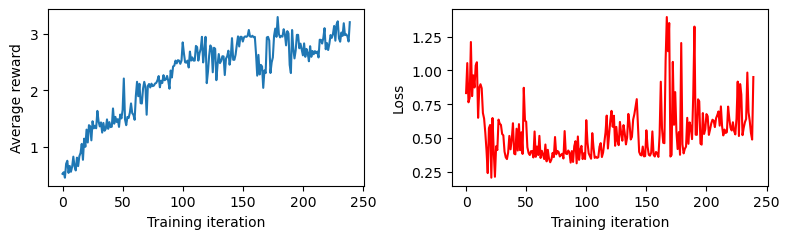

100%|██████████| 100/100 [00:03<00:00, 30.17it/s]


Sample trajectories: 100
[5.468, 4.719, 4.926, 0.017, 0.004, 0.016]    C1COC=CCCSC=NC=C(C1)C(C2=NN=NN2C3CCCC3)C=CC=CC(C(=O)NC4=C5C=CC=C4)(C5)NCC6=CC=CO6
[6.539, 6.644, 5.771, 0.137, 0.166, 0.082]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC(F)=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(Br)=C4)OCC5=CC=C(Cl)C=C5Cl
[6.458, 6.913, 6.565, 0.117, 0.269, 0.350]    CC1=CC=C(C=C1)S(=O)(=O)N(C2=CC(Cl)=CC(Cl)=C2)CC(=O)NCCSCC3=C(F)C=CC=C3Cl
[8.437, 9.278, 7.646, 2.017, 3.584, 1.535]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5C6CCC(C5)(CC6)CCO
[5.339, 5.096, 4.839, 0.013, 0.008, 0.013]    C1COC=CC(NC2=CC=C3C(=C2)OCCO3)=CC=C1OC4=CC=C([N+1](=O)[O-1])C=C4[N+1](=O)[O-1]
[6.246, 6.231, 5.926, 0.078, 0.076, 0.110]    O=CCC=CC=CN=CCOC(=O)C1=CC=C2N=C(N)N(C2=C1)CC3=CC=CC=C3
[4.642, 4.121, 4.289, 0.003, 0.001, 0.004]    CCOC=CC(C(=O)OC1)=CC(Br)=C(O)C(Br)=C1CCCl
[8.354, 9.613, 7.263, 1.874, 4.240, 0.991]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5CCCC(C5)(C6=CC=C(Br)O6)OC

[8.791, 8.600, 7.504, 2.654, 2.305, 1.320]    CCOC1=CC(=CC=C1OCC(=O)N2CCOCC2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5C6CCC(C5)(CC6)NC7=C8C=C(O)C=C7C9=CC=CC=C9C8
[8.638, 9.654, 7.572, 2.375, 4.321, 1.421]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)(C(=O)NC6=CC=C(C=C6)S(N)(=O)=O)CC=NC7=CC=CC=C7S(O)(=O)=O
[6.272, 6.236, 5.926, 0.082, 0.077, 0.110]    O=CC=CC=C1C=CC=CC12OC3=CC=C(Br)C=C3NC2C4=CC=CC=C4O
[7.979, 9.133, 6.978, 1.282, 3.304, 0.671]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4F)C5CCCC(C5)C=CC6C=C7CC6CC8=CC=CC=C8C7=O
[6.262, 7.547, 5.998, 0.081, 0.742, 0.126]    CCOC1=CC(=CC=C1OCC2=CC=CC(=C2)[N+1](=O)[O-1])C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(Cl)C(Cl)=C4Cl
[5.446, 5.194, 5.404, 0.016, 0.010, 0.040]    C1COC=CC(C2=CC(Br)=CC=C2O)=CC=C1OCC(=O)NC3=CC(=CC=C3Cl)C(F)(F)F
[8.906, 9.205, 7.596, 2.870, 3.443, 1.457]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CC6CC(C5)CC(C6)CCCC=NC7=CC=CC=C7[N+1](=O)[O-1]
[6.939, 5

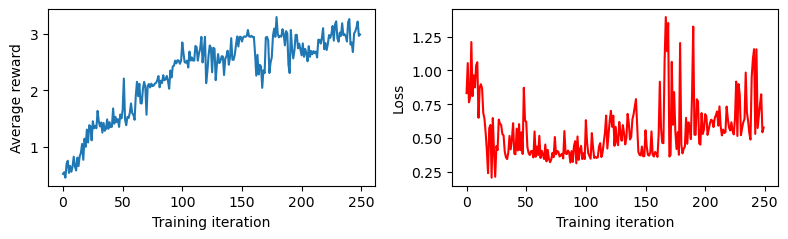

100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Sample trajectories: 100
[5.644, 5.364, 5.231, 0.024, 0.014, 0.029]    O=C(C1=CC=C(N2CCCCC2)C(=C13)[N+1](=O)[O-1])CSC=NN=CCC=C(C)OC=CCCC=CC=C3OC(C)=O
[9.321, 9.333, 7.419, 3.668, 3.691, 1.198]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C5CCC6C(C5)(CC(Br)=C6OCC7=CC=C(C=C7)C(O)=O)Cl
[7.453, 5.865, 5.411, 0.647, 0.037, 0.041]    CCOC=CCCN=C(NC1=CC=C(C=C1)S(=O)(=O)NC2=NC=CC=N2)CSC3=NC=4SC5=C(CCC5)C=4C(=O)N3SS(=O)(=O)N6CCOCC6(Cl)CC=CCl
[6.268, 6.599, 6.271, 0.082, 0.153, 0.209]    O=C(NC1=CC=CC=C1)COC(=O)C(CC2=CC=CC=C2)N3C(=O)SC(C3=O)=CC4=CC=C(C(Br)=C4)OCC5=CC=CC=C5Cl
[5.981, 5.779, 6.359, 0.047, 0.031, 0.245]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)N3C(=O)N(C4=CC=CC(=C4)[N+1](=O)[O-1])C(=O)C3CC5=CC6=CC=C5CC=CN=CC6
[5.025, 5.400, 4.914, 0.007, 0.015, 0.015]    CCOC=CC(N(C)C=S)C=C1C(=O)N=C(O)C(C1=O)CNC(=NC=CBr)CSCC(=O)[O-1]
[6.039, 7.094, 6.121, 0.052, 0.367, 0.159]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(Br)=C4)OCCOC5=CC=CC=C5
[7.850, 7.5

[8.410, 8.968, 7.188, 1.970, 2.987, 0.898]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C(Br)=CCCC5=CC=C(OC)C=C5
[6.245, 5.247, 5.683, 0.078, 0.011, 0.069]    CCC1=CC(=CC=C1Cl)NC(=O)C2=CC=CC=C2NCCCN3CCOCC3SCC(=O)NCC4=CC=CO4
[6.152, 6.402, 5.932, 0.065, 0.105, 0.112]    CCC1=C(C(=O)OC)C(C2=CC=CC=C2)N3C(=N1)SC(C3=O)=CC4=CC=C(C(Br)=C4)OCC5=CC=C(F)C=C5
[6.914, 8.369, 6.900, 0.270, 1.901, 0.598]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(N5CCCCC5)C(=C4)[N+1](=O)[O-1]
[9.143, 8.744, 6.750, 3.323, 2.568, 0.474]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCC5C(C(F)(F)F)C5
[6.620, 7.547, 7.261, 0.159, 0.742, 0.988]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=CC=C4C(=O)NCCC5=CC=CC=C5
[7.659, 8.981, 6.617, 0.865, 3.012, 0.382]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC=C(NC4=CC=C(C=C4)OC(F)(F)F)CCC5CCOCO5
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1]

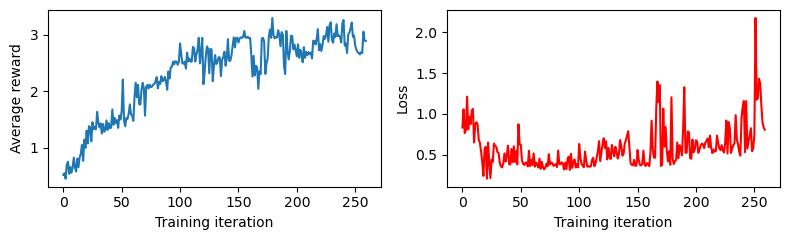

100%|██████████| 100/100 [00:03<00:00, 30.63it/s]


Sample trajectories: 100
[6.688, 6.217, 5.333, 0.180, 0.074, 0.035]    CCOC=CC(NCCC1=CC=CC=C1)=CC(Br)=COCC(=O)NC2=CC=CC=C2C
[7.298, 8.814, 7.436, 0.511, 2.698, 1.222]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)CCCCCSC5=CC=CC=C5C6=C[NH1]C7=CC=CC=C67
[9.557, 8.401, 7.164, 4.130, 1.955, 0.870]    CCOC=CC(C1=CC=CC=C1[N+1](=O)[O-1])C=C2C(=O)NC(=O)N(C2=O)C3=CC4=C(C=C3Br)CCC5CC(=CC6=C5)COCCCC7[NH1]C=CC=CC=C6C=C7C=CN4O
[4.428, 4.246, 4.391, 0.002, 0.001, 0.005]    O=CNC1=CC=CC(=C1)C(=O)N2CCC(CC2)C3=CC=C(C=C3)C(C)(C)C
[7.261, 8.076, 6.608, 0.483, 1.427, 0.376]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CC5CCC(S5)C6=CC=C(C=C6)OC7CCCC7
[6.572, 5.027, 5.366, 0.145, 0.007, 0.037]    CCOC=CCCC=NOCC=C1C(=O)NC(=O)N(C1=O)C2=CC3=C(C=C2Br)CCC4CC3(F)N4CC5=CC=CO5
[8.249, 8.751, 7.014, 1.700, 2.580, 0.707]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CC5C67CC(OC5)N6CC=CC7=O
[6.936, 6.271, 6.491, 0.280, 0.082, 0.308]    CC1=C(Cl)

[7.241, 8.546, 6.758, 0.467, 2.208, 0.480]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4C)C5CCCC(C5)=NC(C6=CC=C(N7CCOCC7)C(=C6)[N+1](=O)[O-1])C8=CC=C9C=CC=CC9=C8
[6.480, 6.182, 5.777, 0.122, 0.069, 0.083]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NC(COC3=CC=CC=C3F)CC4=C[NH1]C5=CC=CC=C45
[8.423, 9.082, 7.149, 1.993, 3.206, 0.853]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)(C6=CC=C7C(=C6)OCCO7)PC(=O)C8=CC=C(Cl)C=C8Cl
[8.285, 9.547, 7.192, 1.759, 4.110, 0.903]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C56CCCC(C5)C6=NC7=CC=C(Cl)C=C7Cl
[5.697, 5.251, 5.440, 0.027, 0.011, 0.043]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCCC
[7.449, 7.030, 7.128, 0.644, 0.330, 0.830]    CCC=CC=NC(C1=CC=C(C=C1)S(=O)(=O)N2CCCCC2)=C(C3=CC=C(C=C3)[N+1](=O)[O-1])C=CCC4C=CC=NN=C=CC(CC5CCCO5)C6=CC=C(F)C=C64
[6.989, 8.041, 7.173, 0.307, 1.373, 0.882]    CCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(C)=C2)C(=O)CN(

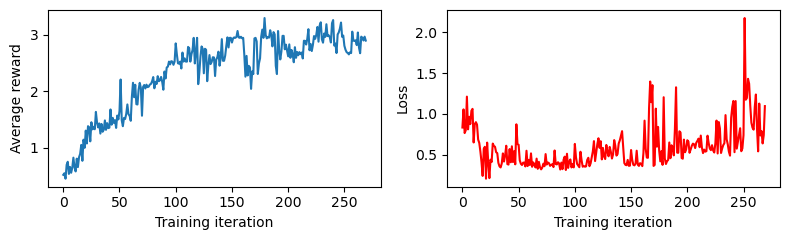

100%|██████████| 100/100 [00:03<00:00, 30.26it/s]


Sample trajectories: 100
[5.938, 5.212, 5.922, 0.043, 0.010, 0.109]    C1COC=CC1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3Br)CCCCCCC=NNC4=CC=C(Cl)S4
[8.953, 7.646, 5.711, 2.960, 0.850, 0.073]    CCOC=C1C(=NN=C1C2=CC=NC=C2)C=C3C(=O)NC(=O)N(C3=O)C=CC=C(C(C)C(=O)NC4CCCCC4)C5CCCC(C5)(C=6C(O)=NC(=O)N(C=6N)CC(C)C)C=O
[9.053, 9.162, 7.392, 3.151, 3.359, 1.160]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5)C6=NC7=CC=CC=C7O6
[8.814, 9.551, 7.376, 2.698, 4.118, 1.139]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)(NC6=CC=C(Cl)C=C6C(=O)C7=CC=CC=C7)C=CCCC(C)=CC(C)(NCC8CCCC=9C8)OCCC%10=CC=C%11C=C%10C=9NC%12=CC=CC(C)=C%12CCOCCO%11
[7.529, 8.613, 7.007, 0.722, 2.328, 0.700]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(N5CCCCC5)C(=C4)C(C)(C)C
[5.831, 5.707, 5.602, 0.035, 0.027, 0.059]    CCOC=CC(CCC(F)(F)F)C=C1C(=O)NC(=O)N(C1=O)C2=CC=C3C(=C2)C(=O)N(C3=O)C4=CC(=CC=C4Cl)[N+1](=O)[O-1]
[8.613, 8.825, 7.169, 2.329, 2.719, 0.87

[6.626, 8.001, 6.658, 0.161, 1.314, 0.409]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCCC(C(O)=O)=NN=CN[NH1]
[8.840, 9.471, 7.257, 2.746, 3.960, 0.982]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCC5C(CC)=C6C=CC=CC6=N5
[6.210, 7.497, 6.298, 0.073, 0.690, 0.220]    CCOC1=CC(=CC=C1OC2=CC=C(C=N2)[N+1](=O)[O-1])C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(Br)C(C)=C4C5=CC=C(C=C5)C6=CC=C(F)C=C6F
[8.533, 8.872, 7.198, 2.185, 2.807, 0.910]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5)S(C)(=O)=O
[8.103, 8.912, 7.605, 1.468, 2.882, 1.471]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CC5CCC(=N5)C6CCCCC6
[7.312, 7.084, 5.950, 0.523, 0.361, 0.115]    C1COC=CC(CC2=CC=CC=C21)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4F)CCCCC(N5C6CC7=CCCCC7)=C5C6=O
[8.239, 9.375, 7.498, 1.683, 3.774, 1.310]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CCCC(C5)C6C=CC7=CC=CC=C76
[8.429, 8.101, 6.653,

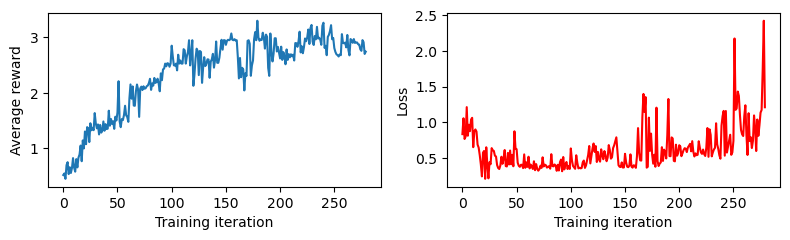

100%|██████████| 100/100 [00:03<00:00, 30.20it/s]


Sample trajectories: 100
[8.472, 8.621, 7.399, 2.078, 2.344, 1.169]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=C6C=C5)CC(=C6C)C(=O)OCC7=CC=CS7
[8.349, 8.678, 7.328, 1.866, 2.447, 1.074]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC(F)=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5)C6=CC=C(C)S6
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[6.815, 6.745, 6.616, 0.227, 0.200, 0.381]    O=C(CC1=CC=C(N(C)C)C(Br)=C1)NCCOCCC2N=CC=CC3=CC(Br)=C(F)C=C3C2=O
[5.778, 4.819, 5.605, 0.031, 0.005, 0.060]    CCCCNC(=O)C(CC)N(CC1=CC=C(C)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC=C(Cl)C(Cl)=C2
[7.773, 7.494, 6.851, 1.003, 0.687, 0.555]    CCOC1=CC(=CC(Br)=C1OCC2=CC=C(Cl)C=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=C5C=C(C=C4)C6C7CCC(C6)N7CC=NN(N5)CC(=O)CCC8=CC=CC=C8
[4.766, 4.259, 4.812, 0.004, 0.002, 0.012]    O=C[NH1]C=CC=C1C=COC(C(=O)C2=CC=CC=C2)C3=CC=C(Br)C=C13
[7.124, 7.196, 5.830, 0.386, 0.435, 0.092]    CCOC

[7.239, 6.403, 6.926, 0.466, 0.106, 0.621]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C56)CC(C)C(C)C6=C
[7.218, 6.911, 6.460, 0.451, 0.268, 0.292]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C=C5)C67C8CCC(C6)C7C8CCC3(NCCCN9CCCC9=O)C%10=CC=CC=C%10
[7.653, 7.980, 6.933, 0.858, 1.284, 0.629]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)NCCCC=5NC(C)=C(C)C=5
[5.266, 4.827, 4.546, 0.011, 0.005, 0.007]    O=C(NC1=CC=C(C=C1)S(=O)(=O)NC2=CC=C3C=N2)C4(O)C3OC5=CC=CC=C5C4CC6=CC=CC=C6F
[7.382, 8.369, 6.871, 0.582, 1.899, 0.572]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5OS(=O)(=O)C6=CC=CC=C6)NCC7=CC=CN=C7
[6.452, 6.668, 5.462, 0.116, 0.174, 0.045]    O=C(C)CCCNC(=O)C=CN(SC=S)C=CC=COCC=CC=CC1=C(Cl)C=CC=C1Cl
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[6.927, 8.235, 6.988, 0.276, 1.677, 0.681]    

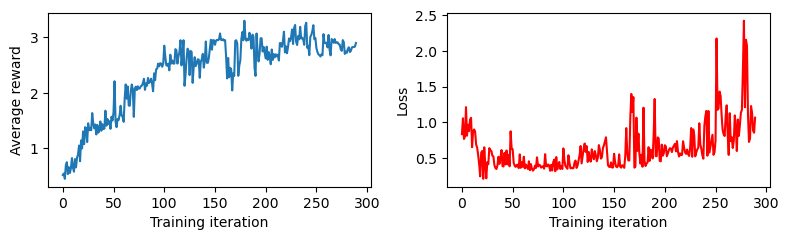

100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Sample trajectories: 100
[7.024, 8.135, 7.302, 0.326, 1.517, 1.040]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC4=C(C)C=CC(Cl)=C4OC5=CC=CC=C5
[6.326, 6.018, 6.053, 0.091, 0.050, 0.140]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)NC(=O)N(C3=CC=CC=C3)C(=O)NCC4=CC=CC5=CC=CC=C45
[9.095, 9.704, 7.794, 3.231, 4.421, 1.774]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5)C6=CC=CC=C6Br
[9.001, 9.506, 7.757, 3.050, 4.030, 1.713]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5)C(C)(C)C
[7.168, 5.716, 5.803, 0.416, 0.028, 0.087]    C1CNC=CSCC=NN=CC=CC(=O)C2=CC(=CC=C21)C3=CC=C(C=C3)C4C5CCC(C4)N5CCCNC(N)=COCC6=CC=CC=C6C(=O)OC(F)(F)C
[7.653, 8.792, 7.030, 0.857, 2.656, 0.723]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=C4C=C(C(C)N4C5=CC=C(Cl)C=C5Cl)C6CCCC(C6)(C(=O)C7=CC=CC=C7F)C8CCS(=O)(=O)C8
[4.735, 4.392, 4.469, 0.004, 0.002, 0.006]    CCC1=CC=CC=C1N(S(C)(=O)=O)CC(=O)N(CC2=CC=CC=C2)C(C)C(=O)NC3CCCC3
[4

[7.052, 7.954, 6.934, 0.342, 1.247, 0.630]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC=C(CC4CCCO4)OCC5=CC=CC(Cl)=C5
[8.889, 9.561, 7.460, 2.839, 4.138, 1.255]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5)CN(C)NC(=O)C6=CN=CC=N6
[7.537, 7.471, 6.361, 0.731, 0.664, 0.246]    CC1=NOC(C)=C1C2=CC=CC(=C2)CCNCCN(O)CCNS(=O)(=O)C3=CC=C(C=C3)C(=O)C=CC=C(C(=O)NC4=CC=C(C=C4)N(C)C)OC(=O)C=CN=C(C5)SC=CC=C(C)C5O
[6.313, 6.951, 6.160, 0.089, 0.288, 0.171]    CCC(C(=O)NC(C)(C)C)N(CC1=CC=C(F)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2C)[N+1](=O)[O-1]
[6.731, 5.866, 6.406, 0.195, 0.037, 0.266]    O=C(NC1=CC=C(Br)C=C1)N2C3=CC=C4N=C(SC4=C3)NN=CC(C2=O)N5CCOCC5
[5.390, 5.498, 5.504, 0.015, 0.018, 0.049]    CCC(C(=O)NCC(C)C)N(CC1=CC=CC(C)=C1)C(=O)CCCN(S(C)(=O)=O)C2=CC=CC(C)=C2
[5.064, 5.101, 5.038, 0.008, 0.008, 0.020]    C1COC=CCCC=2OC=NC=2C(Br)C=C1OCC(=O)NC3=CC=CC=C3OC
[8.245, 8.581, 7.557, 1.693, 2.271, 1.398]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC=C2Cl)C=C3C(=O)NC(

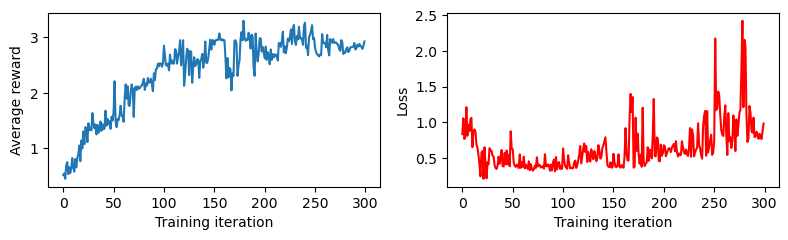

100%|██████████| 100/100 [00:03<00:00, 26.59it/s]


Sample trajectories: 100
[7.785, 8.684, 7.146, 1.019, 2.457, 0.850]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5CC6C7C(C5)(CC(=C7O)[N+1](=O)[O-1])NC=C6C
[7.615, 8.701, 7.416, 0.815, 2.489, 1.193]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCCCCCCOC5=CC=CC=C5OC
[5.889, 5.234, 5.621, 0.039, 0.011, 0.062]    CCOC1=CC(=CC(OCC)=C1OCC)C2=NN=C(N2C3=CC=CC=C3)SCC(=O)NC4=NC(=CS4)C5=CC=C(C)S5
[6.114, 6.964, 7.104, 0.061, 0.294, 0.803]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(=C4)[N+1](=O)[O-1])C=O
[6.879, 6.009, 5.287, 0.254, 0.049, 0.032]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3SC=4N(C3=O)C(C5=CC=CS5)C(=C(C)N=4)C(=O)NC6=CC=CC=C6F
[6.373, 4.868, 4.864, 0.100, 0.005, 0.014]    CCOC1=CC(=CC=C1OCC2=CC3=C4C5=C2F)C=C6C(=O)NC(=O)N(C6=O)C=CC=C(C(=O)C5C3C)CCCCCC=7N=NNC=7CC4
[8.073, 8.756, 7.415, 1.422, 2.590, 1.191]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=C4C=C(CC(Br)=C4OCC5=CC=C(Cl)C(Cl)=C5)C6=CC=C(Cl)C(Cl)=C6Cl


[6.415, 6.693, 6.323, 0.108, 0.181, 0.230]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)NC(=O)N(C(C3=CC=CC=C3)C4=CC=CC=C4)CC5=CC=C(O5)C6=CC(=CC=C6Cl)[N+1](=O)[O-1]
[9.001, 9.506, 7.757, 3.050, 4.030, 1.713]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=CC=C5)C(C)(C)C
[6.507, 6.750, 6.868, 0.129, 0.202, 0.569]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC=COCC=CC=C=C=O
[8.744, 9.013, 7.628, 2.569, 3.072, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[6.317, 7.229, 6.261, 0.090, 0.458, 0.206]    CCOC1=CC(=CC=C1OCC2=CC=CC3=C2F)C=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C=C5Br)CCC6CC3=CC=C6
[5.170, 4.746, 4.946, 0.009, 0.004, 0.016]    O=C(C1=CC=CC=C1NCC2=CC=CC=C2Cl)NC3=CC(=CC=C3N4CCOCC4)S(=O)(=O)N5CCCCC5
[5.830, 6.486, 6.739, 0.035, 0.124, 0.466]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)N(C(=S)N=C3O)C4=CC=C(Br)C=C4F
[6.976, 6.140, 6.958, 0.301, 0.064, 0.652]    O=CC1=CC=NC=C1N2CCC(CC2)CCCCC3=CC=CC=C3OCC(CC4=CC5=CC

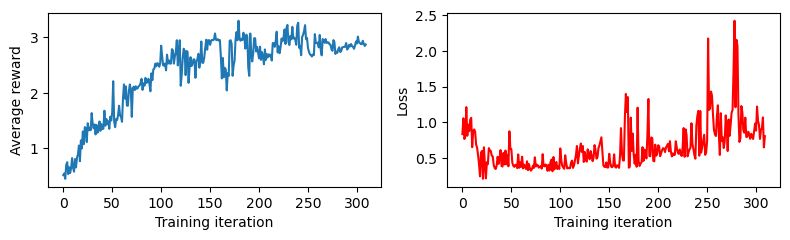

100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


Sample trajectories: 100
[8.903, 9.332, 7.245, 2.864, 3.689, 0.968]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)C5C6CCC(C5)N6C7=CC=CC=C7CC8=CC=CC=C8
[7.311, 7.097, 6.802, 0.522, 0.369, 0.515]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NCNCCC3=CC=C4C=C3CC(CC4)NC(=O)OCCCCCCC5=CC=CC=C5
[5.097, 4.927, 5.238, 0.008, 0.006, 0.029]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC(=CC=C4Cl)CC(C=C)OC5=CC=C6C=C5CCC6
[5.892, 5.894, 6.009, 0.039, 0.040, 0.129]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=N)N4C(=NC3=O)SN=C4S(=O)(=O)C(C)C
[8.810, 9.135, 7.510, 2.691, 3.307, 1.328]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(SC)C=N5
[8.890, 9.068, 7.152, 2.841, 3.179, 0.857]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4F)C5C6CCC(C5)N6C7=CC=C(C=C7)C(C)(C)C8=CC=CC=C8C(C)F
[5.636, 4.859, 5.570, 0.024, 0.005, 0.056]    C1COC=CC(C2=CC=CC(=C2)[N+1](=O)[O-1])=CC(Cl)=C1OCC(=O)NC3=CC=CC=C3F
[7.541, 8.721, 7.174, 0.735, 2.5

[7.754, 7.407, 6.204, 0.979, 0.604, 0.185]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)N4C(=O)N(C3=O)C5=CC=C(C(OC)=C5)C6CCCC(C6)C4C7C=CCC7C(O)(C8=NN=NN8C9CCCC9)C=O
[6.592, 6.907, 6.337, 0.151, 0.267, 0.235]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)NC(=O)N=CC=CCC3=CC=C(C=C3)CCCCCOC4=CC=CC=C4SNC(=O)OCC5=CC=CC=C5C6=CC=C(Cl)C=C6Cl
[7.587, 8.622, 6.699, 0.784, 2.345, 0.436]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(CC)C=C4NC(N)NC5=CC=CC6=CC=CC=C56
[9.392, 9.040, 8.138, 3.806, 3.125, 2.374]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCC5C(Cl)(CC=C5[N+1](=O)[O-1])CC6=NC7=CC=CC=C7O6
[6.138, 6.122, 6.238, 0.064, 0.062, 0.197]    CCOC1=CC=CC(=C1)C(=O)NC(=S)NC2=CC=C3OC(=NC3=C2)C4=CC=C(Br)S4
[3.671, 3.545, 3.515, 0.000, 0.000, 0.001]    O=C(C=COCC)C1=CC(=CC=C1N2CCOCC2)S(=O)(=O)N3CCOCC3
[7.332, 8.142, 7.576, 0.539, 1.528, 1.426]    CCC(C(=O)NCC(C)C)N(CC1=CC=CC=C1C)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.775, 7.763, 6.627, 0.211, 0.991, 0.388]    

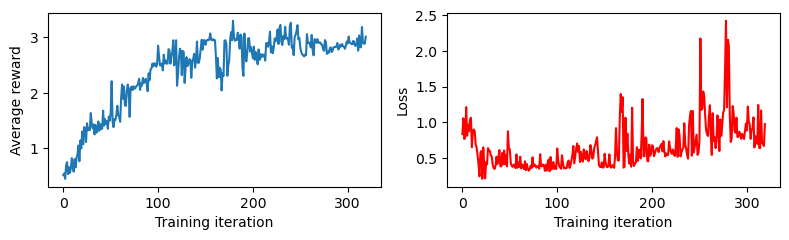

100%|██████████| 100/100 [00:03<00:00, 26.33it/s]


Sample trajectories: 100
[5.524, 4.696, 5.188, 0.019, 0.004, 0.026]    COC1=CC=C(Cl)C=C1NOC2=CC=CC=C2
[7.709, 6.263, 6.619, 0.923, 0.081, 0.383]    CCC(C)(C)NC(=O)C(C(=O)NCC1=CC=C(OC)C(Br)=C1)=CC2=CC=C(C(=C2)[N+1](=O)[O-1])PC=CS(=O)(=O)N(C)C(=NC=C)C3=CC=C(Cl)S3
[5.436, 5.351, 5.205, 0.016, 0.013, 0.027]    CCOC1=CC(=CC(Cl)=C1OCC2=C3C=CC(F)=C2)C=CC(=O)NC(=O)N(CC4=CC=CC=C4)C(=S)N3C5=CC=C(C=C5)C(=O)OCC
[7.490, 7.310, 6.952, 0.683, 0.521, 0.647]    CCOC1=CC(=CC(Br)=C1OCC(=O)OC)C=C2C(=O)NC(=O)N(C2=O)C=C3C=C(CC=C3OCC(=O)NC4=CC=CC=C4Cl)C5CC6CC(C5)CC(C)C6
[6.814, 6.936, 5.923, 0.226, 0.280, 0.110]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=NC6=CC=CC=C6S5
[6.757, 7.174, 6.042, 0.204, 0.419, 0.137]    CCOC(=O)CC1=NN(CC=C1Br)C2=CC(=CC(=C2)C(O3)=O)P(=CC(Br)=C3OCC4=CC=C(Cl)C(Cl)=C4)(CC=CNS(C)(=O)=O)CC(C=O)CCOC5=CC=C(Cl)C=C5CNCCCNC
[8.104, 8.759, 6.724, 1.470, 2.595, 0.455]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)NC(=O)N(C3=CC=CC=C3C)C(=O)C=CC4=CN(C5=CC=C(Br)C=C45)CCC

[7.787, 8.331, 7.698, 1.021, 1.835, 1.617]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.208, 6.838, 5.768, 0.073, 0.236, 0.082]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCCCCCSC=NN=CC5=CC=CS5
[8.734, 9.344, 7.326, 2.548, 3.712, 1.072]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CC5C6CC(=N5)NC6=O
[9.303, 8.762, 6.872, 3.632, 2.601, 0.573]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=C(F)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5CC(=C(Br)C=C5OCC(=O)OC)CC(C)C=O
[9.121, 8.964, 6.801, 3.280, 2.979, 0.514]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCC5C6C(C7=CC=NC=C7)OC6=C5OC8CCC9CC8(CC=C9N%10CCOCC%10)Cl
[7.239, 8.706, 7.148, 0.466, 2.498, 0.852]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)CC5CCC(CC)=NN=C5
[7.844, 8.243, 7.631, 1.095, 1.691, 1.512]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC=C(CC(=O)NC4CCCC4)CCCCC5CCCC=CC=CC=C5CC6C7OC(C)CC6C7
[7

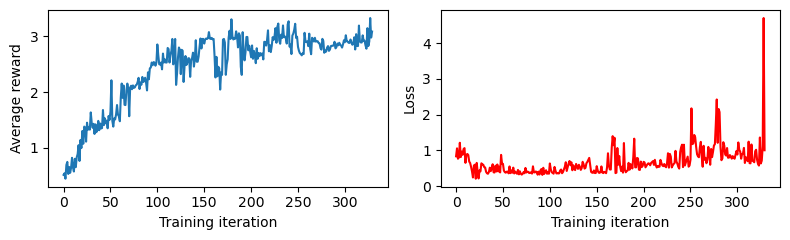

100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


Sample trajectories: 100
[7.609, 8.343, 7.133, 0.808, 1.855, 0.835]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=S)N(C3=O)C4=CC=C(C=C4[N+1](=O)[O-1])CCCC5C(C)=NN=C5
[7.636, 7.210, 6.409, 0.838, 0.445, 0.268]    CCOC1=CC(=CC=C1OC2C3=CC=CC=C3F)C=C4C(=O)NC(=O)N(C4=O)C5=CC6=C(C=C5OC)CCCCCN2[N+1]6
[7.209, 5.885, 5.520, 0.444, 0.039, 0.051]    C1COC=CCCN1C=C2C(=O)NC(=O)N(C2=O)C(C3=CC=CS3)C(=O)NCCOC4=CC=C(C5=C4)S(=O)(=O)CC5C
[8.314, 8.266, 7.252, 1.807, 1.728, 0.976]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=C4C(=O)NC(=O)N(C4=O)C=CC5=C(CO6)CCCCC(C7=CC=CC=C7Cl)CC5C6C=CC=C3OCC8=CC=CC=C8Cl
[7.440, 7.467, 6.711, 0.635, 0.661, 0.445]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC(F)=C2)C=C3C(=O)NC(=O)N(C3=O)C=C4C=C(C(Br)C=C4OCC5=CC=CC=C5F)C(=C)[N+1](=O)[O-1]
[7.279, 8.410, 7.209, 0.496, 1.970, 0.924]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(N5CCCCC5)C(=C4)C(CC)(C)COC=CC=C[NH1]C
[2.449, 2.224, 2.595, 0.000, 0.000, 0.000]    O=C(C(=C)OCC)CC=C
[5.878, 5.237, 5.206, 0.038, 0.011, 0.027]    CCOC1=CC

[5.261, 4.551, 5.761, 0.011, 0.003, 0.081]    C12C(C(Br)=C1)OC=CC=C(Cl)CCCCCN2COC(=O)OCC3=CC=CC=C3
[5.580, 5.080, 5.609, 0.021, 0.008, 0.060]    C=1COC=CCC=1C=C2C(=N)N3C(=NC2=O)SN=C3S(C)(=O)=O
[7.835, 9.522, 7.728, 1.084, 4.061, 1.665]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)OC5=CC=C([N+1](=O)[O-1])C=C5[N+1](=O)[O-1]
[6.593, 7.788, 6.203, 0.151, 1.023, 0.185]    CCOC1=CC(=C(Br)C=C1OCC2=CC=CC=C2Cl)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C45)CCCCC5
[5.897, 4.881, 5.750, 0.040, 0.005, 0.079]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(C3=CC=CC=C3)CNC4=CC=CC=C4C(=O)NNC5CCCCC5CC=CC=NN
[7.063, 7.673, 6.871, 0.349, 0.881, 0.572]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)NC(=O)NC=NC3=CC=CC=C3C4=CC=C(C=C4C)CCC5CC(C(O)=O)([NH1]C=C5)COC6=CC(C)=CC=C6Cl
[6.335, 6.941, 6.352, 0.093, 0.283, 0.242]    C1COC=CC=CC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)CC4CCC(O4)C5=CC=CC=C5OCC6=CC=CC=C6Cl
[8.271, 6.928, 6.521, 1.737, 0.276, 0.325]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)NC(=O)NNC3=CC=CC=CC=

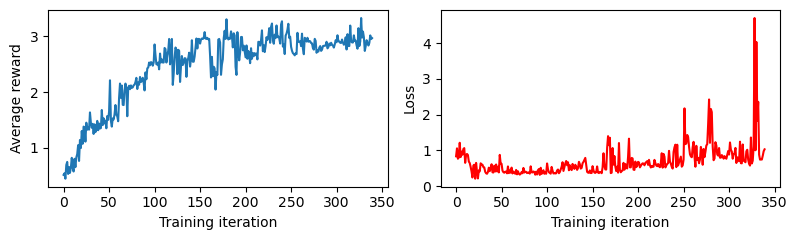

100%|██████████| 100/100 [00:03<00:00, 26.12it/s]


Sample trajectories: 100
[6.600, 6.525, 6.251, 0.153, 0.133, 0.202]    CCC(C(=O)NC1CCCC1)N(CC2=CC=CC(C)=C2)C(=O)CN(S(=O)(=O)C3=CC=C(C)C=C3)C4=CC=C(Cl)C(=C4)C(F)(F)F
[7.005, 6.341, 5.692, 0.316, 0.094, 0.071]    CCOC=CC(NC1=CC=CC=C1C(=O)N2CCCCCC2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CCCCC(F)C=CC5=NC=CC=N5
[8.476, 8.364, 7.116, 2.085, 1.891, 0.816]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CC5CCC(Cl)N5
[6.934, 6.985, 6.208, 0.279, 0.305, 0.186]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=N)NN=C3CSC=NC4=CC=CC=C4C(=O)N3C5=CC=C(C=C5)C(C)(C)C
[6.660, 6.568, 5.987, 0.171, 0.144, 0.124]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(C3=CC=C(Br)C=C3)=C4C(CCC5C4)=CN=CN=C5[NH1]C(=O)NPOC6=CC(C)=CC(C)=C6CCC7CCOCC7
[8.058, 9.402, 7.129, 1.400, 3.826, 0.831]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC=C(NC4=CC=C(C=C4)OC5=CC=C(Cl)C=C5)CCCCC(Cl)(OC6=CC=CC7=C6)N=CC=C7N8C=NN=N8
[8.632, 7.658, 6.585, 2.363, 0.863, 0.362]    O=C(C(=O)NCCC1=CC=CC=C1)CC2C(=NC3=C2C(O)=NC(=O)N3

[8.321, 8.922, 7.633, 1.818, 2.901, 1.514]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C4Br)C5CCC6C(C7CCCCC7)=CC(C5)=C6
[7.554, 7.868, 6.973, 0.748, 1.127, 0.666]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=O)NC(=S)N(C3=CC4=CC(C)=C3)C5=CC=C(C=C54)N6CCCCNC6O
[7.447, 7.543, 6.663, 0.641, 0.737, 0.412]    C1COC=CCC1C2=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)C(=O)N2N=CC(=C)[N+1](=O)[O-1]
[6.621, 7.445, 5.975, 0.159, 0.640, 0.121]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4[N+1](=O)[O-1])OCC5=CC=CC(Cl)=C5
[9.295, 9.088, 7.119, 3.618, 3.216, 0.819]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4)CCCCC(S(=O)(=O)C5=CC=C(Cl)C=C5)CC(NCC6(CCOCC6)C7=CC=CC=C7)CSC=NN=COC=CF
[6.214, 6.507, 5.608, 0.074, 0.129, 0.060]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4F)CCCCC(CC(N)=O)(CC(OCC)=COCC)C(N)=O
[6.348, 6.003, 6.274, 0.095, 0.049, 0.210]    COC=CCNCCCOC=CC=C(C1CCN(CC1)S(=O)(=O)C2=CC=CS2)NC(=O)C=CCC=CNC[N+1](=O)[O-1]
[6.514, 

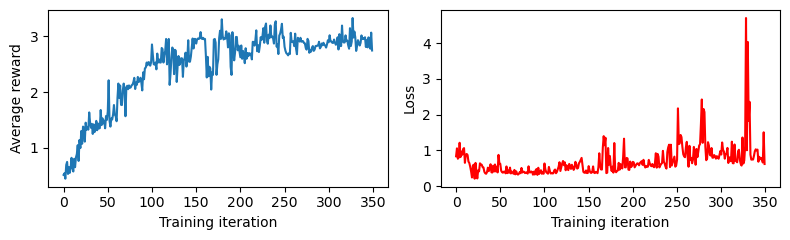

100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


Sample trajectories: 100
[5.798, 5.159, 5.263, 0.033, 0.009, 0.030]    C12COC=CCNC1=CC(Cl)=C2OCC3=CC=C(Cl)C(Cl)=C3Cl
[6.789, 6.847, 5.992, 0.216, 0.240, 0.125]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(F)=C(OC3=CC=C(Cl)C=C3)COC=CC=C(Cl)CS4C5=CC=CC=C5C4
[8.156, 8.243, 7.683, 1.550, 1.690, 1.593]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(OC3)C4=CC=C(C=C4)CCCCC(S(=O)(=O)C5=CC=C6C=C5)(C(Br)C=C6OCC7=CC=CC=C7Cl)C8=CC=NC=C8
[3.661, 3.020, 3.730, 0.000, 0.000, 0.001]    C1COC=CC[NH1]1
[7.673, 6.370, 6.149, 0.881, 0.099, 0.167]    CCOC=CC(C(=O)N1C2COCC1)=CC=C2OC(=O)C=CC3=CC(Br)=CC(Br)=C3OCC4=CC=CC(Cl)=C4
[6.503, 7.052, 7.022, 0.128, 0.342, 0.716]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=C4C=C(CC=C4OCC5=CC=CC(F)=C5)OCC=O
[6.383, 6.970, 6.497, 0.102, 0.297, 0.312]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3Cl)NC(=S)NC(=O)C=CC4=CC=C(O4)C5=CC=C(Cl)C(Cl)=C5Cl
[8.575, 8.403, 7.382, 2.260, 1.959, 1.147]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)C=CC=CCCNCCCCCNCCCCCOC

[6.828, 7.118, 6.711, 0.232, 0.382, 0.445]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(OCC3=CC=CC=C3)CSC=NN=C(O)OC4=CC=C(Cl)S4CN=NC=C5C=C(CC=C5OCC(=O)NC6=CC=C(OC7)C=C6)CCC7
[4.994, 4.960, 4.955, 0.007, 0.006, 0.017]    CCOC=CCCCCCNSC=C1C(=N)N2C(=NC1=O)SN=C2S(C)(=O)=O
[8.789, 8.853, 7.491, 2.652, 2.770, 1.300]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5Cl
[5.425, 5.686, 4.926, 0.016, 0.026, 0.016]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC(=C2)C(O)=O)C=C3C(=O)NC(=O)N(C3=O)CC=O
[7.755, 6.467, 6.217, 0.981, 0.119, 0.190]    O=CSC(C1=CC=C(C=C1)C(C)(C)C)=CC2=CC=C(C=C2)C34C5CCC(C36)(C4)C=CCC5COC=CCC6C7=CC=CC=C7
[6.483, 6.993, 6.278, 0.123, 0.309, 0.212]    CCOC1=CC(=CC(Br)=C1OCC2=CC=C(C=C2)[N+1](=O)[O-1])C=CC(=O)NC(=O)N(C3=CC=C(Cl)C=C3)C(=O)NCCC4=CC=C(C=C4F)CC5=C6C=C(C=C5)C=CC=CC=CC=C6
[5.873, 6.015, 5.962, 0.038, 0.050, 0.118]    CCOC1=CC(=CC=C1OCC2=CC=C3C=CC=CC3=C2)C=C4C(=O)NC(=O)N(C4=O)C=C5C=COCCO5
[5.503, 4.926, 5.081, 0.018, 0.006, 0.021]    C1COC=CC(N(C)C)=CC

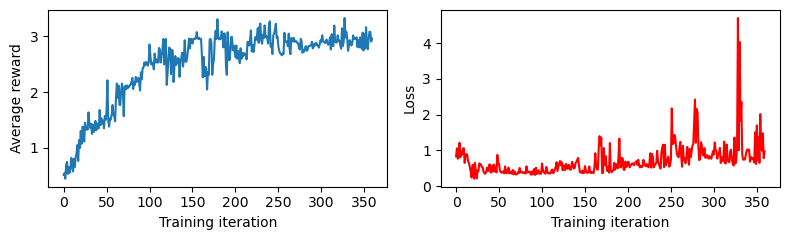

100%|██████████| 100/100 [00:03<00:00, 30.25it/s]


Sample trajectories: 100
[5.810, 5.748, 6.056, 0.034, 0.030, 0.141]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(C3=CC=CC=C3)=CC4=CC=CC(=C4)C(=O)N(C=O)C5=CC=CC=C5F
[5.444, 5.305, 5.132, 0.016, 0.012, 0.024]    C12COC=CC(C1C2=O)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C5C(=C4)CCN5[N+1](=O)[O-1]
[7.800, 7.549, 6.201, 1.037, 0.743, 0.184]    CCOC=CCSC=CC=CC(=O)NC(=O)N(NC(=O)COC1=CC=C(Cl)C=C1Cl)C=CC=CSC=NN=COC(=O)C=CC(N)=C(F)C2C=CCC2NNC3=C4C=CC(Cl)=C3C4=CC=COCC5=CC=CC=C5
[7.126, 7.327, 6.859, 0.388, 0.535, 0.562]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC=C(C(=O)N3C4=CC=CC=C4S5C6=CC=CC=C6)C(=C35)OCCCCCC(CC7=C8C=C(OC)C=C7)C8CC9=CC=CC=C9F
[5.979, 5.862, 6.253, 0.047, 0.037, 0.203]    C1COC2=CC(=CC=C2OCC3=CC=CC=C3F)C=CC(C4=CC=CC(Br)=C4)=CC(C)=CNC1N=NC5=CC=C(C6=C5)OC7=CC=CC=C67
[6.299, 6.591, 6.082, 0.087, 0.150, 0.148]    CCOC1=CC(=CC(Br)=C1OCC2=CC=C(Br)C=C2)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C(O)=C4)CCNC=CCC5=CC=CO5
[6.933, 7.115, 6.309, 0.279, 0.381, 0.224]    CCOC1=CC(=CC=C1OCC2=CC3=CC=C2F)C=CC(N)=CC(=C(C)N3)C(C4=CC(Cl

[6.833, 7.653, 6.675, 0.234, 0.858, 0.420]    CCOC1=CC(=CC=C1OCC2=C(Cl)C=CC=C2Cl)C=C3C(=O)N4C(=O)N(C3=O)C=CC=C=NN4CC5CCC(S5)C6=CC=C(C=C6)OC(=O)C7=CC=C(C=C7)PNC8=CC=CC(=C8)[N+1](=O)[O-1]
[6.678, 5.846, 6.027, 0.177, 0.036, 0.134]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CCCCOCC3=CC(C4)=C(S3)C(=O)NNCCC5=CC=CC=C5C4(C)C
[6.186, 5.605, 6.024, 0.070, 0.022, 0.133]    O=CNC1=CC=C(N2CCCCC2)C(=C1)SCC(=O)NC3=CC=CC=C3C
[7.433, 8.287, 7.000, 0.628, 1.762, 0.693]    CCOC1=CC(=CC=C1OCC2=CC=C3C=CC=CC3=C2)C=C4C(=O)NC(=O)N(C4=O)C5=CC=C(C=C5Br)CC6CCC(C=C6)C=C7SC8=NC9=CC=CC=C9N8C7=O
[7.121, 7.430, 6.205, 0.385, 0.625, 0.186]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NCNC=C3C=COC3=NC4=CC=CC=C4C=O
[8.912, 8.454, 7.213, 2.882, 2.046, 0.929]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)NC(=O)C4=CC(=NC5=CC=CC=C45)C6=CC=C(F)S6
[6.347, 6.814, 5.730, 0.095, 0.226, 0.076]    CCOC=CC=CCS1C(C(C)(C)C2=CC=CC=C21)NC(=O)CCN3C(=O)C4C(C3=O)C5(Cl)C6=CC=CC=C6C4(Cl)C7=CC=CC=C75
[7.395, 8.002, 6.340, 0.593, 1.316, 0.237]    C

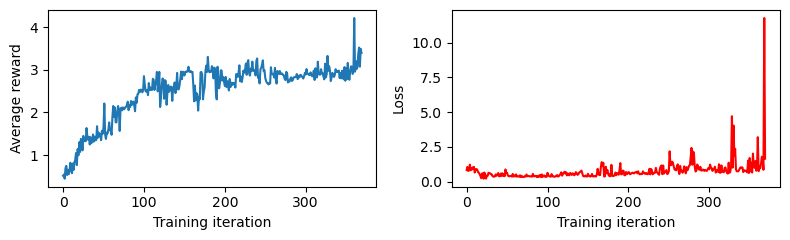

100%|██████████| 100/100 [00:03<00:00, 30.51it/s]


Sample trajectories: 100
[6.109, 5.806, 4.965, 0.060, 0.033, 0.017]    CCOC1=CC(=CC=C1OCC2=C3C=CC4=C2F)C=CC(C4=C3)C=NC(=CC5=CC=C(Br)C6=C5)CC(C=C6OCC)C7=CC=CC=C7[N+1](=O)[O-1]
[5.979, 5.142, 5.413, 0.047, 0.009, 0.041]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(OCC3=CC=CC(Cl)=C3)=CC(C(O)=O)(C(Cl)C4=CCl)CC4
[8.193, 8.178, 6.830, 1.609, 1.585, 0.538]    C1COC=CC(CCNC1=O)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3Br)CC4CCC(Cl)S4
[5.932, 6.449, 5.490, 0.043, 0.115, 0.048]    CCOC=CC=CC=CC=C1C(=O)NC(=O)N(C1=O)C=C2C=C(C(=O)N2C3=CC=CC=C3)N=CC4=CC=C(Br)C=C4
[7.832, 7.470, 6.009, 1.079, 0.663, 0.129]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC(F)=C2)C=C3C(=O)NC(=O)N(C3=O)C=CC=COC4C=CC=C5C=CC=CC5C=C4C=CCN=CSC=C(NC6=CC=C7C(=C6)OCO7)COC8CNCCN8
[6.191, 5.608, 5.776, 0.070, 0.022, 0.083]    CCOC=CCCOC=CC=C[NH1]C=CC=C1C(=N)N2N=C(C3=CC=CN=C3)SC2=NC1=O
[7.005, 7.917, 6.723, 0.316, 1.195, 0.454]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3F)NC(=O)COC(=O)C[NH1]C4=CC=C(Br)C=C4N5CCCCC5COCCNCCCl
[7.222, 5.683, 5.434, 0.454, 0.026, 

[6.222, 6.857, 5.178, 0.075, 0.244, 0.026]    C1COC=CC2(C1=O)C=CC(=O)NC(=O)N(C3=CC=C(F)C=C3)C(N2CC4=CC=CC=C4)C=CC(C5=CC6=C(OC)C=C5)=C(C)C6C(=O)OCC
[6.183, 6.569, 6.057, 0.069, 0.145, 0.141]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(N4CCCCC4)=NC(=N3)NC(=O)C5=CC=C(C(C)=C5)ON
[8.022, 7.432, 6.342, 1.345, 0.628, 0.238]    CCOC=CCNC1=CC=CC=CC=CC=C1C=CC(=O)NC(=O)N(C2=CC=C(Cl)C=C2)C(=O)C(NC3=CC=CC=N3)SC4(C)C=CC(=C4)OCC5C6C5(C)CCCOC7=CC=C6C=C7
[4.270, 3.712, 4.189, 0.002, 0.001, 0.004]    CCOC=CCCCC=CCCC=CC(C(O)=O)=C(CC(=O)N1CCC(O)CC1)C2=CC=C(C=C2)OC(F)F
[6.458, 6.881, 6.895, 0.117, 0.255, 0.594]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CCNC=NN=C=CC(C3=CC=CC=C3)(CC4=CC=CC(C)=C4)NC=CC=C(CC(=O)NC5=CC=C(Cl)C(Cl)=C5)[N+1](=O)[O-1]
[7.798, 7.150, 6.514, 1.035, 0.403, 0.321]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC=CSC3CC(=O)NC4=CC=CC=C4CC5=CC=CC=C5Cl
[6.336, 7.304, 5.932, 0.093, 0.517, 0.112]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=NC4=CC(C(=O)OC)=CC=C4C3=O)CC5=CC=CS5(C=C6SC7=NC8=CC=CC=C8N7C6=O)=CC9=CC(=O)CCC

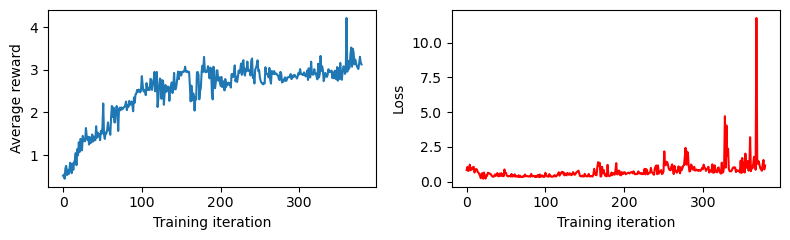

100%|██████████| 100/100 [00:03<00:00, 30.11it/s]


Sample trajectories: 100
[6.670, 6.289, 5.748, 0.174, 0.085, 0.079]    CCOC1=CC(CCC1O)C=CC(=O)NC(=O)N=CC=CC=CC2=CC=C(C=C2Br)CCCCC=CC3=CC=CC=C3
[7.953, 8.432, 6.883, 1.246, 2.007, 0.583]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)CCSC4=NN=NN4C5=CC=C(Br)C=C5
[6.812, 6.379, 5.683, 0.225, 0.101, 0.069]    C1COC=CC=C1C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)CCCCC(NC4=CC=C(Br)C=C4F)C=NC(C=CC5=CC=C(O5)C6=C7C(Cl)=CC(Cl)=C6)(CN7)OC=CCCC(OC)(C(=O)NCCCN8CCCCCC8)O
[6.408, 6.687, 6.211, 0.107, 0.180, 0.188]    O=CCCCCCNSC1=CC=C2C(=C1)C(=O)N(C2=O)C3=CC=C4C(=C3)C(=O)N(C4=O)C5=CC=C(C=C5Cl)CC6=CC=CC(=C6)C(F)(F)F
[7.994, 7.316, 7.184, 1.305, 0.526, 0.894]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)CCC(=O)N(C3=CC=CC(F)=C3)C(C(=O)NC4CCCC4)C5=CC=C6N=CC=CC6=C5
[8.460, 6.875, 6.697, 2.056, 0.252, 0.435]    CCOC1=CC(Br)=C(C=C1OC)C=CC(=O)NC(=O)N(N)C=CC=C(N2CCCCC23)CCCCC3(C=4C(C)=NN(C=4O)C5=CC=CC=C5)OCCCCC=CC=C6C7=C(N)N=CN=C76
[6.828, 7.969, 6.560, 0.232, 1.268, 0.347]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)CC3C4CN(C3)CC

[6.361, 6.984, 5.968, 0.097, 0.305, 0.119]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=CC(=O)NC(=O)N(C3=CC=CC=C3C)C(=O)NC4=CC=C(C=C4)OC5CCCC5F
[7.251, 8.122, 6.780, 0.475, 1.498, 0.497]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C(=O)NCCCOCC4=CC=CC(=C4)OC5=CC=CC=C5C
[6.402, 6.415, 6.386, 0.105, 0.108, 0.257]    CCOC1=CC(=CC(Cl)=C1OCC(=O)NC2=CC=CC=C2)C=CC(=O)NC(=O)N(CC3=CC=CC=C3Cl)C(=O)C=CC(C4=CC=CC=C4C)=CC=CC5=CC=[N+1](C(=C5C6)C(=O)OC)C6SCC(=O)NC7=CC=CC=C7
[8.629, 8.747, 6.679, 2.358, 2.574, 0.423]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)NC(=O)C4=CC=C(C=C4)N5C=C(N=N5)CNC(C6)C(=O)NC(C)C(=O)NC6CC7=CC=CC=C7
[6.349, 7.319, 6.061, 0.095, 0.528, 0.142]    CCOC1=CC(=CC=C1OCC2=CC=CC(=C2)[N+1](=O)[O-1])C=C3C(=O)NC(=O)N(C3=O)CCCCCC(=O)NC4=CC=C(C=C4)N=NC5=CC=CC=C5
[6.646, 6.006, 6.218, 0.167, 0.049, 0.190]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC3=CC=C(C(Cl)=C3)N4CCN(CC4)C=C(F)C(F)=C(F)CNC5CCCC5C(O)=O
[3.716, 3.356, 4.027, 0.001, 0.000, 0.003]    O=C(C)NC1=NC=C(S1)C=CBr
[8.618, 7.533,

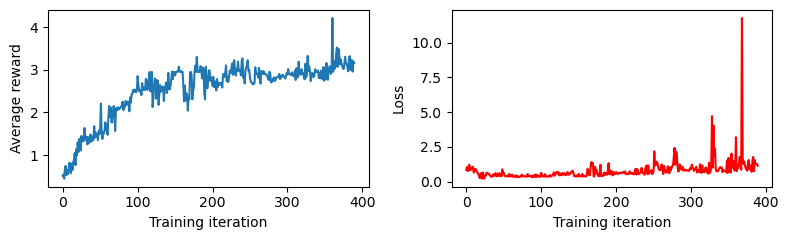

100%|██████████| 100/100 [00:03<00:00, 31.48it/s]


Sample trajectories: 100
[6.763, 7.983, 7.201, 0.206, 1.289, 0.914]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(Br)=CC=C3NC(=S)NC(=O)C4=CC=C(O4)C5=CC(=CC=C5Cl)[N+1](=O)[O-1]
[5.918, 5.702, 5.404, 0.041, 0.027, 0.040]    CCOC1=CC(=C(Br)C=C1O)C=CC(=O)NC(=O)NC(=O)N(CC=COCC2=CC=C(Br)C=C2)CCCNC(=O)C(C)CC3=CC=CN=C3
[8.969, 8.339, 6.167, 2.989, 1.849, 0.173]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(C3=C4C=CO3)=CC(=N4)CC5=NC(=N[NH1]5)C=CC6=C7C=CC=C6C=C7OC8C(C9=CC=NC=C9)C8C%10=C(Cl)C=CC=C%10Cl
[3.576, 3.403, 3.864, 0.000, 0.000, 0.002]    CCOC=CC(C(=O)OC(C)C)=CC
[5.958, 6.154, 5.894, 0.045, 0.066, 0.104]    C1COC=CCOCCN2C=C=C(CN2C1=O)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(C=C4Br)CC=5CC6C(CC)(N6C7=CC=C(OC)C=C7)C(C)N=5
[6.350, 6.553, 5.728, 0.096, 0.140, 0.076]    CCOC1=CC(=CC=C1OCC2=CC=CC3=CC=C4C=C23)C=CC(=O)NC(=O)NCC5=CC=C(C=C5)CC6CCC=C4N6CC7=CC=CC=C7
[5.807, 5.421, 5.697, 0.033, 0.016, 0.071]    CCOC1=CC(C=C2C(=O)N(N=C2C)C3=CC=CC=C3)=CC=C1OC4=CC=C(C(F)(F)F)C=C4[N+1](=O)[O-1]
[8.977, 9.046, 6.685, 3.005, 3.137,

[5.644, 5.010, 4.908, 0.024, 0.007, 0.015]    CCOC=CC(C1=NN=NN1CC2=CC=C(OC)C=C2)C=CCCl
[8.127, 8.484, 7.469, 1.505, 2.099, 1.268]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3Cl)NC(=O)C4=CC(=NC5=CC=CC=C45)C6=CC=C(Br)S6
[6.741, 6.254, 6.532, 0.198, 0.080, 0.331]    CCOC1=CC(=CC=C1OCC2=CC=CC3=C2F)CC([NH1]C3=O)(CC)CC4=CC=CC=N4
[7.169, 7.521, 6.602, 0.416, 0.714, 0.372]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)CCCCN(CC3=C4C=C(Br)C=C3)CCSCN=CC5=CC=C(F)C=C5S(C6=CC=CC7=C6)C4(N[NH1]7)NC=C8NSC9=CC=CC=C98
[6.526, 7.328, 6.409, 0.133, 0.536, 0.268]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(Br)=CC=C3NC(=O)C4=CC(=NC5=CC6=CC=C45)C=CC=CC6=O
[6.498, 6.880, 5.291, 0.126, 0.254, 0.032]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=C(C3)C=C2)C=CC(=O)NC(=O)N(C=O)C(C4=CC=CC=C4)C(=O)C3=CC=5C=C(C)N(C=5C)C6=CC=C(C=C67)SC=CC=C7Cl
[6.364, 7.027, 6.544, 0.098, 0.328, 0.338]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2Cl)C=CC(=O)NC(=O)N(C3=CC=CC(Cl)=C3C)N=C(C4=CC=CS4)NSC5=NC=CC=N5
[6.416, 6.993, 5.958, 0.108, 0.310, 0.117]    CCOC1=CC(=CC=C1OC2=CC=C(C=

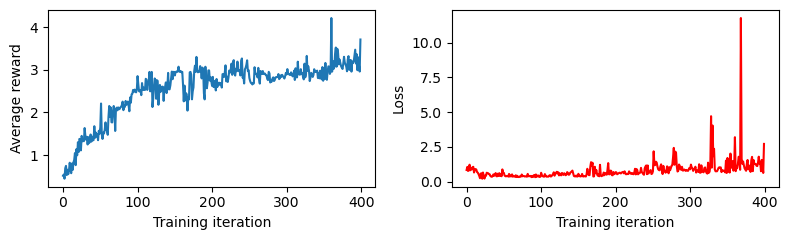

100%|██████████| 100/100 [00:03<00:00, 31.56it/s]


Sample trajectories: 100
[5.783, 5.389, 6.160, 0.032, 0.015, 0.171]    C1COC=CCC1C=CC(=O)NC(=O)N(C2=CC=C(F)C(Cl)=C2)N=CCC3=CC=C(Br)C=C3
[4.423, 3.605, 4.386, 0.002, 0.000, 0.005]    O=C(C)CCC(=O)OCC(=O)NC1=CC(Cl)=CC=C1Cl
[7.137, 8.188, 7.435, 0.395, 1.601, 1.219]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=O)N(N=C3C(F)(F)F)C=CC=CNCCOCCOC=CC=CN=NC=C(CC(Br)=COCC4=CC=CC(=C4)C(O)=O)CC=5SC6=CC=CC=C6C=5Cl
[6.476, 6.989, 5.687, 0.121, 0.307, 0.070]    C12COC=CC=NN1C=CC(=O)NC(=O)N(C3=CC=CC(Cl)=C3)C(=O)N2C=NC4=CC=CC=C4NC5=CC=C6C=C5C7=CN=CN=C7C=CC(Br)=COC(C)CC(=O)N6PNC8=CC=C(F)C(F)=C8F
[7.973, 8.241, 7.107, 1.274, 1.687, 0.806]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC4=C3O)NC(=O)CCC(NC5=CC=C6C(=C5)OCO6)CC4COC7=CC=C(C)C(C)=C7
[8.257, 9.119, 7.599, 1.713, 3.277, 1.461]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(=NC4=CC(=CC=C43)S(=O)(=O)N(C)C)CSC=NC5=CC=CC=C5N6N=NN=C6CC7=CC=CC(Cl)=C7Cl
[5.305, 4.760, 5.040, 0.012, 0.004, 0.020]    CCC(C)NC(=O)C(CC)N(CC1=CC=C(OC)C=C1)C(=O)CN(C2=CC=CC(Br)=C2)S(=O)(=O)C3=CC

[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[7.353, 6.214, 5.275, 0.557, 0.074, 0.031]    CCOC=CCCOCCOC=CC=CCC=CC(=O)N(C(C)NC1=CC=C(F)C(Cl)=C1)C2=CC=C(C=C2)C3=NC4=CC=CC=C4[NH1]3
[7.263, 8.005, 6.970, 0.484, 1.321, 0.664]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)NC(=O)C=C4C=C(N(C5=CC=CC=C5)C(=O)C4CC)C6=CC=C(C(=C6)C(O)=O)[N+1](=O)[O-1]
[7.925, 8.519, 6.801, 1.205, 2.161, 0.514]    CCC(C(=O)NC)N(CC1=CC=C(C)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.451, 8.293, 7.555, 2.041, 1.772, 1.394]    CCOC=CC(CCC1=CC=CC(C)=C1)C=CC(=O)N2C(=O)N(C(C)=C2)CC3=CC=C(O3)C4=CC(=CC=C4C)C(O)=NN(S(C)(=O)=O)OC5OC(C(O)C(O)C56O)(C7=CC=CC(=C7)OCC8=CC=CC=C8)OC(C)(C)C6CO
[6.033, 6.715, 7.299, 0.052, 0.189, 1.036]    CC(=O)CSC=NN=CN(CC1=CC=C(Cl)C(Cl)=C1)C(=O)C=C2N=C(CC=C2CCl)PNC3=CC(Cl)=C(Cl)C=C3Cl
[7.987, 8.895, 8.054, 1.294, 2.849, 2.223]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)NCC=CC=NC4=CC=CC=C4N5CCCCC5
[6.586,

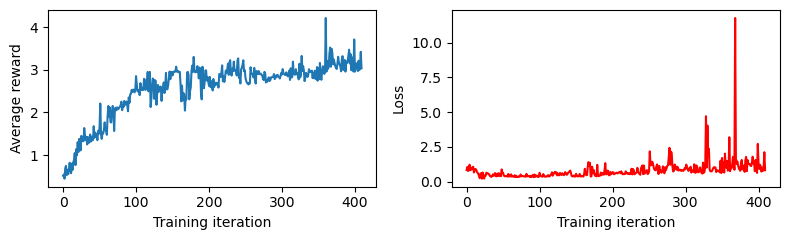

100%|██████████| 100/100 [00:03<00:00, 30.25it/s]


Sample trajectories: 100
[6.566, 6.609, 6.430, 0.144, 0.156, 0.278]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CCNCCCCC=CCNCCC3=CCCCC3NS(=O)(=O)C4=CC=C(C=C4)C(C)(C)COC(=O)C5=CC=CC=C5Cl
[6.863, 7.217, 5.920, 0.247, 0.450, 0.109]    CCOC1=CC(=CC=C1OCC2=CC=C3C(=C2)[N+1](=O)[O-1])C=CC(=O)NC(=O)N(C4=CC=CC=N4)C(=O)CC5C=CC6=CC=CC=C6N53
[6.713, 7.048, 5.966, 0.188, 0.340, 0.119]    CCOC=CCCCC=C1C(=O)NC(=S)N(C1=O)C=CC=C(Br)C=C(CC2=CC=CC3=CC=CC=C23)SC4=NN=C(N4CC)CCC5CC6=CC=CC=C6S5
[5.682, 4.974, 5.198, 0.026, 0.006, 0.027]    CCOC=CCCN=CSCC=CCNCC=CC=C(NC1=CC=C(Cl)C(=C1)C(F)(F)F)CC=CC=CC=NC2=CC=C(Cl)C=C2
[6.453, 6.046, 4.810, 0.116, 0.053, 0.012]    CN1C(=O)[NH1]C(=O)C=C1N=C(N2CCN(CC2)C3=CC=CC=C3)CSC4=NN=C(N4N)CSC5=CC(Cl)=CC=C5Cl
[5.486, 5.008, 5.299, 0.018, 0.007, 0.033]    CCOC=CCC=NSCC=C1N=C(OC1=O)CSC=CC(C)C=CCl
[7.775, 8.936, 6.607, 1.006, 2.928, 0.376]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)NC(=S)NC(=O)C4=CC=C(N5CCCC5)C(=C4)[N+1](=O)[O-1]
[6.862, 6.838, 6.570, 0.246, 0.236, 0.353]    CCOC1=C

[5.922, 5.358, 5.806, 0.042, 0.014, 0.088]    C12COC=CC(C=C1)=C(Br)C=C2OCC3=CC=C4C=CC=CC4=C3
[8.763, 8.111, 6.168, 2.602, 1.481, 0.173]    CC1OC=CC(N1CC)C=CC(=O)NC(=O)N(C2=CC=CC(Cl)=C2Cl)C(C(=O)NC(C)(C)C)C=CC(OCC)=C(OC(C3)=O)C(=CC=C3O)CNCCCN4C5CCC4(N5)O
[5.210, 4.996, 5.849, 0.010, 0.007, 0.095]    O=[N+1]([O-1])C1=CC=CC(=C1)C=NN=CCC2=CC=NC=C2SCC(=O)NC3=CC=CC=C3Br
[8.347, 8.990, 7.176, 1.863, 3.029, 0.885]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C(C4=CC=CC(Br)=C4)NC(=O)CC5=CC=CC(=C5)C(=O)NCC6=CC=CC=C6F
[5.757, 5.309, 5.367, 0.030, 0.012, 0.037]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CCC=3N=N[NH1]N=3
[6.464, 6.181, 5.552, 0.119, 0.069, 0.054]    CCOC=CCNCCCOCC=CC=CCC=CC(=O)NC(=O)N(CC1=CC=C(C=C1)[N+1](=O)[O-1])C2=CC=C(C=C2)CCCCCNCCCCCCOC3=CC=CC4=C3P=CC=C4OCC5=CC=CC=C5F
[8.271, 7.677, 7.490, 1.736, 0.885, 1.298]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(C3=CC=CS3)=CC=CC(C(C)(C)C4)=C(N)CS(C4C5=CC6=CC(Br)=C5)(=O)C7=CC=CC(Br)=C76
[6.620, 7.097, 6.552, 0.159, 0.369, 0.343]    CCOC1=CC(=CC(Br)=

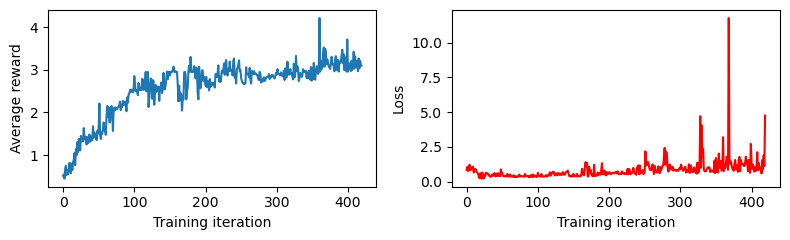

100%|██████████| 100/100 [00:03<00:00, 30.34it/s]


Sample trajectories: 100
[6.456, 6.339, 5.446, 0.117, 0.094, 0.044]    CCOC=CC(C=CS(=O)(=O)N1CCCC2C1)C=CC(=O)NC(=O)N(C3=CC=CC=C3)C(=O)C2C4=CC=CC=C4
[7.701, 8.043, 7.328, 0.915, 1.376, 1.075]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Br)=C5Cl
[6.639, 6.617, 6.120, 0.164, 0.158, 0.159]    CCOC=CCS=CC=CC(=O)NC(=O)N(C1=CC(C)=CC(C)=C1)CC(=O)NCC2=CC=CC(=C2)CN3CCOCC3
[6.131, 6.974, 6.056, 0.063, 0.299, 0.141]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)CC3(C(=O)OC)C4=CC(=CC=C4N5CCOCC5)OCC=CC3=O
[6.408, 6.758, 6.422, 0.107, 0.204, 0.274]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=NC4=CC=CC=C34)NC(=O)C5=CC=C(C=C5)NC(=C)C(O)=O
[6.477, 6.938, 5.993, 0.122, 0.281, 0.125]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC3=CC=CC=C23)C=CC(=O)NC(=S)N(C4=CC=C(C=C4)N(C)C)C5=C(C)N(C)C6=CC=CC=C65
[6.515, 6.414, 6.315, 0.131, 0.108, 0.227]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CCCCCCCC=CC=C=CC(=O)NCCCCCC3=CC=C4C(=C3)C(=O)N(C4=O)C5=CC=C(C=C5)C6=CC=CC=N6
[7.443, 8.591, 7.477, 0.637, 2.288, 1.279]    CCC(

[7.882, 6.994, 6.710, 1.146, 0.310, 0.444]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=CC(=O)NC(=O)N(C3=CC(C)=CC(C)=C3)C=NC=C[NH1]C=CC=C=CC=CN4CCN(CC4)CC5=CC=CC=C5F
[5.715, 5.342, 5.456, 0.028, 0.013, 0.045]    CCCOC1=CC2=CC=C1C(=O)NC(=NC2=CCl)CC3=NC4=C5C=CC6=C4S3(=NC6=C5)C7=CC=C(Br)S7
[5.902, 5.497, 6.047, 0.040, 0.018, 0.139]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(=C)OCCNCSC=CC=CCC3=C(F)C=CC=C3Cl
[5.895, 6.039, 6.584, 0.040, 0.052, 0.361]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)NNC(=O)C3=CC=CO3
[7.177, 7.885, 6.854, 0.421, 1.150, 0.557]    CCC(C(=O)NC(C)C)N(CC1=CC=C(F)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.633, 7.034, 6.593, 0.163, 0.332, 0.367]    CCOC1=CC(=CC=C1OC2C3=CC=CC=C3F)CNC(C2)=NC(C)(C4=CC=C(C=C4)OCC5=CC=CC=C5)PNC(=O)C6=CC=C(Br)C=C6C7=CC=CC=CC=CN=C7
[6.699, 6.967, 6.726, 0.184, 0.296, 0.456]    CCOC1=C2C(=CC=C1OCC3=CC=CC=C3F)C=C4C(=NN=C24)OCCOC(C=5SC6=CC(Cl)=CC=C6C=5Cl)(C7=C8C=C(C=C7)OC9=CC=C(C=C9)[N+1](=O)[O-1])C8OCC%10=CC=CC=C%10F
[6.528, 6.929, 6.119, 0.134, 0.277, 0.159]  

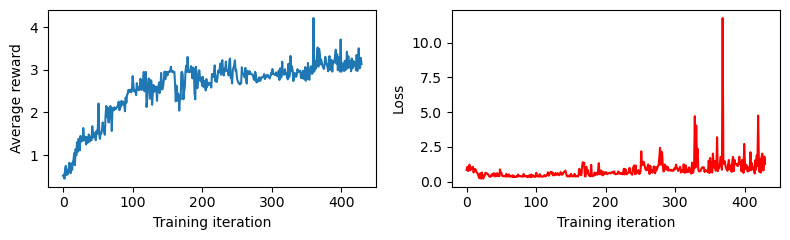

100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


Sample trajectories: 100
[8.286, 9.031, 7.202, 1.760, 3.107, 0.915]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)N=NC=CC4=C(C=CC=C4C5=NC6=CC(Cl)=CC=C6O5)N=NC=C7C=C(C(=O)NC8C(C)C)N9N8CC%10=CC=CC=C%10C7OC(=O)N[CH0]NC(C)=NCNN=C9
[6.041, 5.673, 5.588, 0.053, 0.026, 0.058]    C12COC3=CC(=CC=C3OCC4=CC5=CC=C4F)CC=CN6NC17CC2(NN7C6=O)CCC=NN=CC58C=CC=C9N=C(C%10=CC=C(OC)C=C%10)C9CC(=O)C8CCC%11=CC=CC=C%11
[4.647, 4.614, 4.786, 0.003, 0.003, 0.012]    O=C1C=C(S)N(CC1)C2=NN=C3N2N=C4C=CC=CC4=N3
[6.447, 5.650, 6.224, 0.115, 0.024, 0.192]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)CC(C(=O)OCC3=CC=CC=C3)=C(C)NC=NC(N4CCCCC4)=NNCN5CCCCC5
[7.828, 7.673, 6.875, 1.074, 0.881, 0.576]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(N3CCC4=CC=CC5=C4C3)(CC(Br)=C5OCC6=CC=CC=C6)NC(C)ONN=NCCOC7=CC=C(Cl)S7
[5.540, 5.653, 5.108, 0.020, 0.025, 0.022]    CCOC1=CC=C(C2=C1)C(=O)NNC(=O)C(C)[NH1]C2SC(C[N+1](=O)[O-1])C=CC3=CC(C)(C)C4=CC(=CC=C43)S(O)(=O)=O
[5.437, 5.916, 5.966, 0.016, 0.041, 0.119]    COC1=CC=C(OC)C(=C1)N(S(=O)(=O)C2=CC=C(C)C

[6.313, 6.121, 6.135, 0.089, 0.062, 0.163]    C1C(CC1)N2C(=O)NC(C2=O)=CC3=CC(Br)=C(C(Br)=C3)OCC4=CC=CC=C4Br
[6.205, 6.203, 5.718, 0.072, 0.072, 0.074]    CCOC1=CC(=CC(Br)=C1OCC(=O)OC)C=CSC2=NC3=CC(C)=C(C)C=C3N2CCCN4CCOCC4CNCCOCC5CCCCC5[N+1](N)=O
[6.359, 6.486, 7.332, 0.097, 0.124, 1.079]    CCOC1=CC(=CC2=C1OCC3=CC=CC=C3F)C=CC(=C2OC)S(N)(=O)=O
[4.952, 5.429, 4.594, 0.006, 0.016, 0.008]    C12COC=CC(C3=CC=C(OC)C(OC)=C3)=CC4=C1C(CN4C(=O)C5=CSC6=C5CCCC6)OCC(=O)OCNC7=CC=CC=C72
[7.925, 9.171, 7.685, 1.206, 3.376, 1.596]    C1COC=CCN1C=CC(=O)N(CCOC2=CC=CC=C2Cl)C=CC3=C(Br)C4=CC=C3C=C5N=C(OC5=O)C6=C(C)C=C(Cl)C=C46
[5.136, 4.726, 4.547, 0.009, 0.004, 0.007]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2Cl)C=CC(=O)N3C(=O)N(C=C3C)C=CC=C(C(=O)C4=CC5=NC=C46)C7C8CCC(C8SC59)=NC%10=CNCCC%10OC796
[6.094, 5.484, 6.028, 0.058, 0.018, 0.134]    C1C(=CC(Cl)=C1OCC(=O)NC2=CC=C(C3)C=C2)C=CC(OC4=CC=CC=C4)=NC=CN3C5=CC=C(Cl)S5
[7.271, 7.865, 6.780, 0.490, 1.124, 0.497]    CCOC=CC(OCC)=C(C(C1)C)C2=CC(=CC=C2O)CCC(=O)N(S(=O)(=

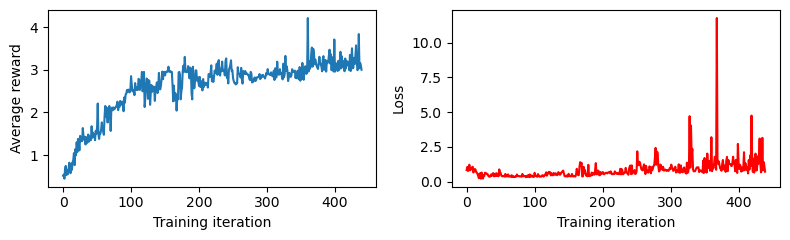

100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Sample trajectories: 100
[6.771, 7.535, 6.747, 0.209, 0.728, 0.471]    CCOC1=CC(=C(Br)C=C1OCC(=O)NC2=CC=CC=C2)C=CC(=O)NC(=O)N(CCC3=CC=C4C=C3)C(C5=C(Cl)C=CC=C5Cl)=NC(=N4)NC6=NC=NN6
[6.294, 6.519, 5.972, 0.086, 0.132, 0.120]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NCCOC=NC=CCOCCN(CC)CC3=CC=CC=C3OC(F)F
[7.173, 7.213, 6.268, 0.419, 0.446, 0.208]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C=C2)C=CC(=O)NC(=O)N(C3=CC=CC=C3)C(=O)N(C=O)C4=CC=C(C=C4Br)C5CCCC(C(=C5)[N+1](=O)[O-1])(NC6=CC=CC7=C8C=CC=C67)C8OCN=C9C=CC=CC9(CC%10=CC(Br)=C(O%10)N%11CCCCC%11)CCCC=O
[6.853, 6.220, 6.129, 0.242, 0.075, 0.161]    CC1OC=CC(=C1O)C2=CC(=O)N(N=C2S3)C=CC=C=CCC=C3NCCCCCC=CC4=C(CC)NC5=CC=CC=C45
[3.119, 2.985, 3.770, 0.000, 0.000, 0.002]    C(C)#N
[8.225, 8.393, 6.684, 1.660, 1.941, 0.426]    CCOC=CC(COC1=CC=CC(Cl)=C1)C=CC(=O)SS(=O)(=O)C2=C3C=CC=C2NC3C4=C5C=CC6=C4OC5=CSC67NC=C(C78C)C(=O)OC(O8)CCCCCCC=CCCC=9OC=NC=9NC(=O)OC(C)(C)C
[7.880, 7.568, 6.701, 1.143, 0.764, 0.438]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC=C2Cl)C=C3C(=O)N4C

[7.280, 7.099, 5.978, 0.497, 0.370, 0.122]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC(F)=C2)C=C3C(=O)NC(=O)N(C3=O)CC=4C=CSC=4SC=5OC(C)=CC(=O)C=5OC=CCSC(C(=O)OCC)CCOC6COC=CC=CCC=C6CSC=CC=CCCC=NN=C7NCN7NCCCN8CCOCC8
[5.655, 5.188, 5.652, 0.025, 0.010, 0.065]    O=CNC(=O)N(NC1=CC2=CC(Cl)=C1)C=CC=C2C=CC3=CC=C(O3)C4=CC=CC=C4
[7.040, 7.716, 6.843, 0.336, 0.933, 0.549]    CCOC1=CC(=CC=C1OCC2=CC=C(C=C2)[N+1](=O)[O-1])C=CC(C3=CC=C(SC)C=C3)CCCOC=CC(C4=CC(OC)=C(OC)C=C4)C5=NC=NO5
[8.326, 6.358, 5.875, 1.827, 0.097, 0.100]    CCOC1=CC(=CC(OC)=C1OC)C(CCCC)=C(O)OC=C(C(=O)N)CNC2CCC(S2)NC(=O)NCCC3=CC=CC=C3N=NC4=CC=CC=C4
[7.401, 7.079, 6.490, 0.599, 0.358, 0.308]    C1COC=CC=C1C=CC(=O)NC(=O)N(S(=O)(=O)N(C)C)CC(=O)N(CC2=CC=CC=C2)CC3=CC=CC4=C3C(C)=NN4CC(O)(C(=O)CSCC5=CC=CC=C5)C=O
[5.486, 4.714, 5.022, 0.018, 0.004, 0.019]    O=C=CNC(CC1=C[NH1]C2=CC=CC=C12)C(=O)NCCC3=CC=C4C(=C3)OCO4
[6.521, 6.278, 5.434, 0.132, 0.083, 0.043]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=C(Cl)C(Cl)=C2)C=C3C(=O)NC(=O)N(C3=O)C4CCCCCCCCC=NN4CC5=CC6=CC=C

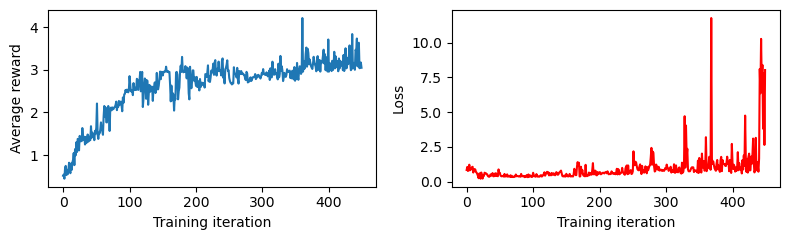

100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Sample trajectories: 100
[6.815, 7.093, 5.915, 0.227, 0.367, 0.108]    CCOC=CC(C1=CC=C(Cl)C(=C1)C(F)(F)F)=CCCSCCCNCC=CC(=O)NC(=O)N(CC2=CC=C(Cl)C=C23)C=NC4=CC=CC5=C4C3COC=CC=C[NH1]C=C5CNC(=O)COC6=CC=C(C=C6)C(C)C
[5.091, 4.726, 5.269, 0.008, 0.004, 0.031]    O=C(C(=O)NCC1=CC=C(F)C=C1)NC2=CC=C(C=N2)C(F)(F)F
[5.885, 5.623, 5.245, 0.039, 0.023, 0.029]    C1COC=CCCNC=CC=C(OCC)C=C1NC(=O)C2=CC(=NC3=CC=CC=C23)C4=CC=C(Br)S4
[5.910, 5.910, 5.560, 0.041, 0.041, 0.055]    O=CCNC1=CC=C2N=C(SC2=C1)SCC(O)=NC3=CC=CC=C3OCNCCCOCCOCOC(N)CCS4C=NC5=CC=CC=C54
[5.859, 5.174, 5.269, 0.037, 0.009, 0.031]    CC1=CC=CC=C1NC(=O)COC2=CC=C(C=C2)C=C3SC(=O)N(C3=O)CC(=O)N4CCC5=CC=CC=C5C4CC
[5.993, 5.310, 6.165, 0.048, 0.012, 0.173]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(C3=CC=C4C(=C3)OCO4)=CC=C5NC=CC6=CC=CC=C56
[5.358, 4.560, 5.029, 0.014, 0.003, 0.019]    C1CCNC(=O)C(=O)NN2C1=CC3=CC(Cl)=CC=C32
[5.681, 5.461, 5.048, 0.026, 0.017, 0.020]    CCOC1=CCCNCCCNC2=CC(C(=O)N2C1C3=CC=C(OC)C(OC)=C3)=CC=C(N)NOCC4=CC=CC=C4F
[6.045, 

[5.708, 5.269, 5.222, 0.027, 0.011, 0.028]    CCOC1=CC(=CC(Cl)=C1OCC(=O)NC2=CC=C(F)C=C2)C=CC(=O)NC(=O)NOCCO
[6.476, 6.769, 6.031, 0.121, 0.208, 0.134]    CCOC=CC(NC1=CC=C(Br)C=C1Br)C=CC(=O)N(CC2=CC=CC(Cl)=C2)NC3=CC=CO3
[5.621, 5.518, 5.260, 0.023, 0.019, 0.030]    COC(=O)C1=CC=CCC=CCCCC=CCC=C1C(=O)NC2CCN(CC2)S(=O)(=O)C3=C(Cl)C(Cl)=C(Cl)C(Cl)=C3C=O
[6.298, 5.384, 4.947, 0.086, 0.014, 0.016]    CCOC=CCOCNCCCC=CC(=N)NN=C(C(C)C(=O)NC)CC1=CC=C(Cl)S1
[6.121, 4.825, 4.953, 0.062, 0.005, 0.017]    C12COC=CCN1C=C3C(=O)NC(=O)N(C3=O)NC2C=CC=C(F)CF
[8.534, 7.033, 6.048, 2.188, 0.331, 0.139]    CCOC=CCNCCN1CCOCC1C=C2C(=O)NC(=O)N(C2=O)NCC3CCCNC=CC=CC=CS3(NC4=CC=C(C=C4)S(=O)(=O)NC5=CC=C(Cl)C6=C5)OCCCC7=CC=CC=C7C6(N8CCN(CC8)C(C9=CC=CC=C9)C%10=CC=CC=C%10)CCC%11N%12C(N)(CC=C%12NS(C)(=O)=O)C%11O
[5.806, 5.098, 5.104, 0.033, 0.008, 0.022]    CCOC1=CC(=CC(Br)=C1OCC(=O)OC)C=C2C(=O)NC(=O)N(C2=O)C=NNC(=NC=C)C3=CC=C(Br)S3
[7.439, 7.721, 6.859, 0.634, 0.938, 0.562]    CCOC=CC(N=CC)C=CC(C1=CC=CC=C1)=NCCC2NNN=CC3

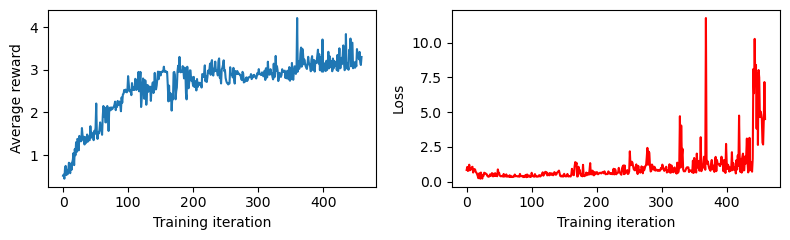

100%|██████████| 100/100 [00:03<00:00, 29.03it/s]


Sample trajectories: 100
[5.868, 5.551, 5.178, 0.037, 0.020, 0.026]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2Cl)C=CCBr
[5.982, 5.362, 5.834, 0.047, 0.014, 0.093]    C1COC=CC(=N1)C(Br)C=CN=C=NC=CC=C([N+1](=O)[O-1])C=C(CC2=C3C=C(Cl)C=C2)[NH1]C4=CC=CC=C34
[7.113, 6.325, 6.271, 0.379, 0.091, 0.209]    C1COC=CC1C2=CC(OC2=O)CCC(=O)N(CC)N=CC3=CC(Br)=CC=C3OCCN4C(=O)C5CCCCC5C4=O
[7.903, 7.045, 7.466, 1.175, 0.338, 1.264]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(CC3=CC=C(Cl)C=C3)=NC(CC(=O)N4CCCCC4)SCC(=O)N5CCN(CC5)C6CCCCC6
[8.097, 9.162, 7.467, 1.459, 3.359, 1.266]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C4=NC(=N[NH1]4)SCC(=O)NC5=NC(=CS5)C6=CC=C(Br)S6
[7.101, 7.341, 7.317, 0.372, 0.547, 1.059]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=C3C(NC4=C5C=CC=C4)=NC(=N3)NC(=S)NCC6(CCCCC6)C7=CC=C(F)C=C57
[6.905, 6.282, 6.133, 0.266, 0.084, 0.163]    CC(C)NS(=O)(=O)C1=CC=C(C=C1)CCC(=O)NC2=CC=C(C3=C24)C(=O)OCC(=O)NCSC=CC4C3C
[6.785, 7.473, 5.985, 0.215, 0.667, 0.124]    CCOC1=CC(=CC=C1OC2C3=CC=CC=C3F)C4=CC(=CC=C4O)C=CCC5

[7.042, 8.057, 7.415, 0.336, 1.398, 1.193]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)N4C=NC(N=NNC5=CC=CC=C45)=NC=CCNC6CCCC6[N+1](=O)[O-1]
[5.439, 5.669, 5.874, 0.016, 0.025, 0.100]    C=CC(=O)CNCCCCCCOC1=C2C=C3C=C1C=NC2CC3=O
[7.375, 7.192, 6.217, 0.576, 0.432, 0.190]    O=C(CC(Br)=COCC)NC1C=NN=C(C1[N+1](=O)[O-1])CCCC2C(S3C(=S4)N2C5=CC=CC=C5)=C6C=C4C3(C7=NC8=CC=CC=C8N=C67)CC9=CC%10=C(OCO%10)C=C9CC(=O)CC%11=CC=CC=C%11Cl
[5.402, 4.744, 5.179, 0.015, 0.004, 0.026]    O=C(C=C1NC(=O)N(C1=O)CC2=CC=CC=C23)NC=NC=C(SC=C3)SCC(=O)NCC4=CC=CO4
[5.988, 6.159, 5.257, 0.047, 0.066, 0.030]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)CNC3=CC=CC=C3CC(=CC=COCC4=CC=C(F)C=C4)C5=CC=C(C=C5)OC(=O)COC6=CC=C(Cl)C=C6Br
[5.694, 5.628, 6.047, 0.027, 0.023, 0.139]    C1COC=CC(NC2=CC=CC(Cl)=C2Cl)=CC=C1OC3=CC=C(C(F)(F)F)C=C3[N+1](=O)[O-1]
[7.174, 6.504, 5.467, 0.420, 0.128, 0.046]    CCOC1=CCCCON=CC=CC(C23CC4CC(C2)CC(C4)C3)=CC=C1C5=CC=CC=C5NCC6=CNC(=O)N6CC7=CC=CC(OC)=C7
[5.607, 5.060, 4.891, 0.022, 0.008, 0.015]    CCOC1=CC(

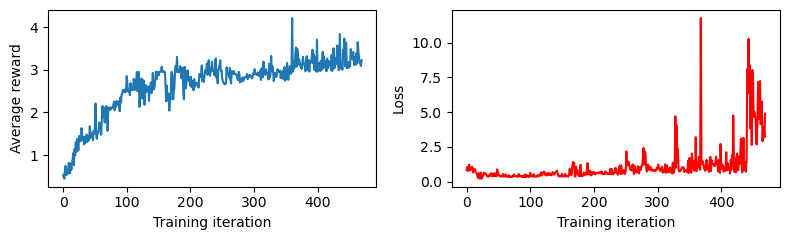

100%|██████████| 100/100 [00:03<00:00, 28.83it/s]


Sample trajectories: 100
[6.370, 6.319, 6.056, 0.099, 0.090, 0.141]    CCOC1=CC(=CC(Cl)=C1CC2=CC=CC=C2Cl)C=CC(=O)NC(=O)N=CC=CC=CC3=CC=C(C=C3)OCCOC4=CC=CC=C4Br
[8.514, 7.754, 6.841, 2.151, 0.979, 0.547]    CCOC=CC(C(C)=C)C=C1C(=O)NC(=O)N(C1=O)C2=CC=C(C=C2)CC3CCC(N3CC4CCCO4)CCCOC5=CC=CC=C5Cl
[6.269, 6.255, 5.784, 0.082, 0.080, 0.084]    CCOC=CC(NC1=CC=CC=C1Cl)=CC2=CC=CN2NC(=O)C3=CC=CC(=C3)CN4C=C(C5=CC=CC=C54)C=CCCC=NCS6C=C(CC=C6CCl)OCC7=CC=CC=C7
[7.364, 6.994, 6.815, 0.566, 0.310, 0.525]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(C3=CC=CC=C3)=CC=CC=C=NC(C(=O)NCC4=CC=CC=C4Br)(C5=CC=C(C=C5)N6CCCC6=O)NCC7=CC=CC=C7
[5.613, 4.523, 5.352, 0.023, 0.003, 0.036]    CCCCCCOC1=CC=C(C=C1F)C2=NN(C3=CC=CC=C3)C=C2C=CCF
[7.492, 7.057, 6.804, 0.685, 0.345, 0.516]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CCC=CN=NC=CC=C(C(=O)C3=CC=C(Br)C4=C3)N=NC=CC(N)=CC(=C4)C(O)CCCCC5=CC=C(O)C(O)=C5CCCO
[6.270, 6.403, 6.134, 0.082, 0.106, 0.163]    CC1=CC=C(C=C1)NC(=O)CCC(C2=CC=CC=C2)=NN=CC(=O)CC[NH1]C(C3=CC=C(F)C4=C3)(C5=CC=C(C=C5

[8.502, 9.114, 7.192, 2.131, 3.268, 0.904]    CCOC1=CC(=CC(Br)=C1OCC2=CC=CC=C2)C=CC(=O)NC(=O)N(C3=C[NH1]C4=CC=CC=C34)C=CC=CNCCC5C6CCCCCCCOC=CC7=C8CC(Cl)=CC=C8C567
[7.148, 7.340, 7.004, 0.402, 0.546, 0.697]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)OCC=CC=C(NC4=CC=C(C=C4)[N+1](=O)[O-1])CC=CCC5=CC=CC=C5CC=CC=NN
[6.053, 6.921, 5.923, 0.054, 0.273, 0.110]    CCOC1=CC=CC=C1N(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC=C(C)C(=C3)[N+1](=O)[O-1]
[6.225, 5.702, 6.284, 0.075, 0.027, 0.214]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)NCC3NC=CC=C3
[2.989, 3.017, 3.241, 0.000, 0.000, 0.001]    SCC1=CC=CC=C1C=O
[8.501, 9.438, 7.650, 2.129, 3.897, 1.541]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C4=CC=C(C=C4[N+1](=O)[O-1])C5=CC#CC(OC)=C5
[5.860, 5.169, 6.030, 0.037, 0.009, 0.134]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(NCC3=CC=C(F)C=C3)CNC4=CC=NC=C4CC5=CC=CC=C5
[5.598, 5.680, 5.409, 0.022, 0.026, 0.041]    CCOC1=CC(=C(Br)C=C1OCC2=CC=C(Cl)C=C2Cl)C=C3NC(=O)N(C3=O)CC(=O)NC4=CC=CC(F)=C4
[6.085, 6.597, 6.117, 0.057, 0.1

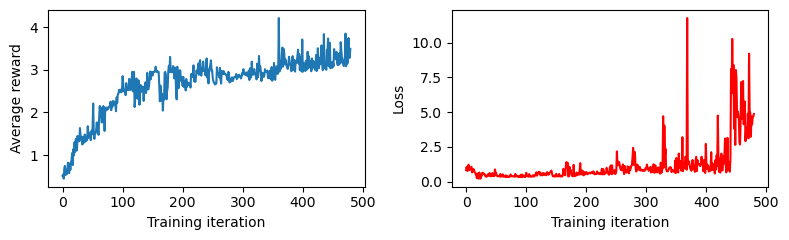

100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Sample trajectories: 100
[6.277, 6.000, 5.817, 0.083, 0.049, 0.090]    CCOC=CCNC=NC=NC=CC=CCCSCCC(=O)NC(=S)NC=C1C(C2=CC=CC=C2N1CC3=CC=CC=C3F)C4=NC5=NC=CC=C5O4
[6.296, 6.085, 5.584, 0.086, 0.057, 0.057]    CCOC1=CC(=CC(Cl)=C1OCC2=CC(C)=CC(C)=C2)C=C3C(=N)N4N=C(SC4=NC3=O)CN5CCN(CC5)CC6=CC=CC=C6
[9.208, 9.497, 7.483, 3.448, 4.012, 1.289]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)CC(C(=O)OC)=C(SC=C3)NC4=NN=C(C=C4S3)NCCC(C=O)C5CCS6C=NN=C(C5O)N6ONC7=CC=CC=C7Cl
[8.279, 9.089, 7.523, 1.749, 3.220, 1.347]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C(=CC=CO)C4=CC(Br)=C(C(Br)=C4)OC(=O)C5=CC=CC(=C5)[N+1](=O)[O-1]
[7.567, 8.004, 6.495, 0.762, 1.319, 0.311]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3C)C(C(=O)C4=CC=C(Br)C=C45)COCN6C=CN=C6CNCCCC(C5)CC7=CC=CC=C7OC
[7.350, 6.349, 5.444, 0.554, 0.095, 0.044]    CCOC=CCCCOCCCNCC=CC(=O)NC(=O)N(C1=CC=CC(F)=C1)CC2=C[NH1]C=CC=CC=C2CC=CC(C3=CC=C(OC)C=C34)=C(NN=C4C5=CC(OC)=CC(OC)=C5)N6CCOCC6
[7.681, 7.911, 6.389, 0.890, 1.186, 0.258]    C1COC=CC(C=C1Br)C=CC(=O)NC(=

[9.838, 8.660, 7.165, 4.685, 2.414, 0.872]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)CSC4=NN=C(N4CC)CCCNC5=CC=CC=C5F
[6.678, 7.167, 6.566, 0.177, 0.415, 0.351]    CCOC=CC(NC1=CC=C2C(=C1)OCCO2)C=C3C(=O)N(C(=O)N=C3O)C4=CC=C(C=C4)C(N)=O
[4.813, 4.971, 4.552, 0.005, 0.006, 0.007]    CCOC1=CCNCCN1C=C2C(=N)N3N=C(SC3=NC2=O)CC(=O)N4CCCC4
[5.474, 5.555, 5.497, 0.017, 0.020, 0.048]    COC(=O)C1=CC=C(O1)CN2C(=O)NC(C2=O)=CC=CN=NNC3=CC=C(Br)C=C3
[8.315, 8.651, 7.440, 1.808, 2.397, 1.226]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)NN=CCC=CCN=CSCC(=O)C=CN=C(S(=O)(=O)CC)C4=CC=CC5=CC=CC=C45
[7.808, 8.380, 7.229, 1.048, 1.918, 0.948]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[7.152, 6.761, 6.599, 0.405, 0.206, 0.371]    C1COC2=CC(=CC=C2OCC3=CC=CC=C3F)C4=CC(=CC=C4O)N(C1)C=NCN=CC=CC5=NC(=CC(Cl)=C5OCC6=CC=CC7=CC=CC8=C67)CC(=C8C)CCC(O)=O
[6.790, 6.318, 5.904, 0.217, 0.090, 0.106]    C1COC=CC(OCC2=CC3=C(Br)C=C24)C13SC(=S)N4C5=CC=C(Br)C(Cl)=C5
[7.524, 8.331,

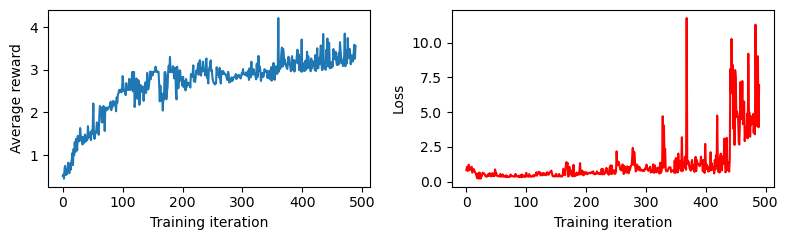

100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Sample trajectories: 100
[5.632, 6.513, 5.667, 0.024, 0.130, 0.067]    COC1=CC(=CC(OC)=C1OC)C2NC(=O)C=CCOC=CC=C2OCC3=CC=CC(=C3)OC4=CC=CC(Br)=C4CNCCNCCCC(O)=O
[6.754, 7.037, 6.232, 0.203, 0.334, 0.195]    CCOC1=CC(=CC=C1OCC2=CC=C(Cl)C(Cl)=C2)C=CC(=O)NC(=O)N(C(=O)C3=CC=C(C)C4=C3)C=NC5=CC=CC=C5NN=CC=C(C(C)CC)CNCCC6CC4(C(Br)C=C6OCC7=CC=C(C)C=C7)OC8=CC=C(C)O8
[7.639, 7.144, 6.851, 0.842, 0.399, 0.555]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CC(CC3=CC=C(C=C3)[N+1](=O)[O-1])=NC4=CC=C(C=C4[N+1](=O)[O-1])C=CN5CCCCCC5C6=CC=C(Br)C=C6
[6.086, 5.420, 5.811, 0.057, 0.015, 0.089]    C1COC=CCC1C=C2C(O)=C(C(=O)OCC)CCCC=CC=C2CC=COCC3=CC=CC=C3Cl
[7.379, 8.003, 7.093, 0.579, 1.317, 0.790]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3)C(SCC(=O)NC4=C5C=C(Br)C=C4)=C(O)C6=CC=C(N)S6(O)OCC=NNCC5COC7=CC=C(Cl)C=C7
[6.230, 6.614, 6.006, 0.076, 0.157, 0.128]    CC1OC=CC(C=C1Br)C=CC(=O)NC(=O)N(N2CCN(CC2)C(C3=CC=CC=C3)C4=CC=CC=C4)C=CC5=C(Br)C=CC(=C5)C6=NC7=CC=CC=C7O6
[7.837, 7.495, 7.421, 1.086, 0.688, 1.201]    CCOC1=CC(

[6.335, 6.220, 6.544, 0.093, 0.074, 0.338]    CCOC1=CC(=CC=C1OCC2=CC=C3C4=CC=CC=C24)C5=CCOCCCOC=CC=C=NC(=N5)NCC3NC(=O)C6=CC=C(Cl)C=C6Cl
[8.928, 8.473, 7.098, 2.913, 2.079, 0.796]    CCOC=CC(CC1=C(Cl)C=CC=C1Cl)C=C2C(=N)N3N=C(SC3=NC2=O)C=CC(S(=O)(=O)C4=C5C=C(C)C=C4)C5O
[6.606, 5.340, 5.307, 0.155, 0.013, 0.033]    CCOC=CC(S(=O)(=O)C1=CC=C(Br)C=C12)CCCOC3=CC=C4C=C3C=CC=5CSC=NN=C(C2)C[NH1]C=5N4C6=CC=CC=C6[N+1](=O)[O-1]
[7.160, 6.211, 5.836, 0.410, 0.073, 0.093]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC4=C3O)C=NC=CC5=C(CCN(C4)CC6=C7C=CC=C6)C=CC=C5OC8OC(CO)C(O)C(O)C8OC(O)C7NC=NC=C
[7.914, 7.409, 6.156, 1.191, 0.607, 0.169]    CCOC1=CC(=CC=C1OCC2=C3C=CC=C2F)C4=CC(=CC=C4O)OC5C6=CC(=CC=C6O)C=NCC=C[NH1]C=CC=C[NH1]C(NC3=O)C5(COC7=CC=CC(Cl)=C7)SC8=C9C=C(OC)C(C)=C8N(CC)CCC9(C(=O)NCC%10%11CCCO%10)SC%11CC(Br)=COCC%12=CC=CC(Cl)=C%12
[7.006, 7.217, 6.557, 0.317, 0.450, 0.345]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC4=C3O)C5=CC=C(C5C4=O)OC6OC(CO7)C(C(O)C6O)COC(=O)CCCCC(C7)CCN
[5.264, 4.529, 4.902, 0.

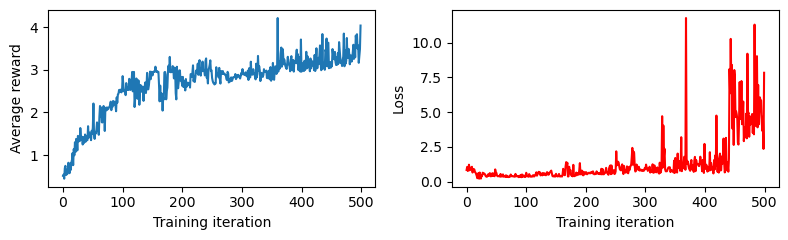

100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Sample trajectories: 100
[4.330, 4.016, 4.374, 0.002, 0.001, 0.005]    CCOC=C1C(C(C)=NN1C)C2=CC=CC=C2O
[7.216, 7.434, 6.817, 0.449, 0.630, 0.527]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C4=CC=C(C(=C4)S(O)(=O)=O)C=CN=C(NC5=CC=C(C=C5)S(=O)(=O)N6CCCCC6)CNC(=O)C=CC=CC=C(Cl)CCCSC=NCCC
[6.266, 6.519, 5.486, 0.081, 0.132, 0.047]    CCOC=CC1=NC(Br)=NC(=N1)NC(=S)NCCNC2=CC=CN=C2C3=CC=C(F)S3
[5.936, 5.797, 5.457, 0.043, 0.033, 0.045]    C1COC2=CC(=CC=C2OC3C4=CC=CC=C4F)C5=CCCCCCC5=COC31OC6=CC=C(Br)C=C6
[7.605, 7.528, 7.122, 0.804, 0.721, 0.822]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C=CCC=COC=CCCNCCCCCOC3=C4C=CC5=C3N=C6C=CC=CC6=C5C(=O)N4CCC7=CC=C(Br)S7
[6.484, 7.675, 7.095, 0.123, 0.883, 0.792]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=CC=C2F)C=C3C(=O)NC(=O)N(C3=O)OCOC=CCCC(=O)N4CCN(CC4)C(C5=CC=CC=C5)C6=CC=CC=C6
[7.192, 5.959, 5.973, 0.432, 0.045, 0.121]    CCOC1=CCC=CCN1C=CC(C)=CCCC2=NC=CN2C3=NC4=CC=CC=C4N=C3C5=CC(Cl)=CC=C5OCC(N)C=6OC7=CC=CC=C7C=6O
[4.716, 4.965, 4.672, 0.004, 0.006, 0.009]    CCOC1=CC(=CC(

[6.902, 6.962, 6.816, 0.264, 0.293, 0.526]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)NOC4=CC=CC=C4
[7.642, 7.580, 6.872, 0.846, 0.776, 0.573]    CCOC=CCCSC=NN=CC1=CC=CC=C1C=C2C(=O)NC(=O)N(C2=O)CC3=CC(=CC=C3O)CCC4CC(NC5=CC(C)=C(C)C=C5Br)C(C(=S)N6CC7OCC6)(C(C)=N7)N4CC(CSC8=CC=CC=C8)NS(=O)(=O)C9=CC=CS9
[7.473, 8.651, 7.747, 0.666, 2.398, 1.696]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C=CC=CSCC=NC4=CC=CC=C4NCC5=CC(Br)=C6C=C56
[7.414, 7.635, 7.426, 0.611, 0.837, 1.207]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C4=CC=C(N4CC5=CC6=CO5)SC=NC(O6)=NCSC=C(CSCC7=CC=C(Cl)C=C7Cl)C8CCCCC8
[7.398, 7.734, 6.474, 0.596, 0.955, 0.299]    CCOC1=CC(=CC(Cl)=C1OCC2=CC=C(F)C=C2)C=CC(=O)NC(=O)NNC=CC=COCC=CC=C(C3=CC(=CC=C3Cl)[N+1](=O)[O-1])C4CCCCC4(NC5=CC=CC(Cl)=C5Cl)CCOC6=CC=CC=C6S=CCC=C(O)CC(O)C=CSC7=NC=CC=N7
[5.794, 6.630, 6.083, 0.032, 0.162, 0.148]    CCOC1=CC(=CC=C1OCC2=CC=CC=C2F)C3=CC(=CC=C3O)C4=CC=C(C=C4F)C5=NC(=CC=C5OCC6=CC=CC=C6)C7=CC=CC(=N7)C8=CC=C(C=C8)OCC9=CC=CC=C9Cl
[7.973, 8.722, 

In [22]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

ba_A_list = []
ba_B_list = []
ba_C_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.1
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(grad_clipping=1., alpha=alpha)
    
    ## append - reward
    #reward = simple_moving_average(tr_rewards, cur_reward)
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    #rl_loss = simple_moving_average(rl_losses, cur_loss)
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    #reconst_loss = simple_moving_average(reconst_losses, cur_reconst)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    #entropy_loss = simple_moving_average(entropy_losses, cur_entropy)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_ba_A = 0.
    avg_ba_B = 0.
    avg_ba_C = 0.
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, ba_A, ba_B, ba_C, score_A, score_B, score_C = my_reward_ft(sm, debug=True)
                print(f"[{ba_A:.3f}, {ba_B:.3f}, {ba_C:.3f}, {score_A:.3f}, {score_B:.3f}, {score_C:.3f}]    {sm}")
                avg_ba_A += ba_A
                avg_ba_B += ba_B
                avg_ba_C += ba_C
            avg_ba_A /= len(smiles_cur)
            avg_ba_B /= len(smiles_cur)
            avg_ba_C /= len(smiles_cur)
    
    ## append - binding affinity values
    ba_A_list.append(avg_ba_A)
    ba_B_list.append(avg_ba_B)
    ba_C_list.append(avg_ba_C)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
    

# 3. Save

In [23]:
ReBADD.generator.save_model(model_path)

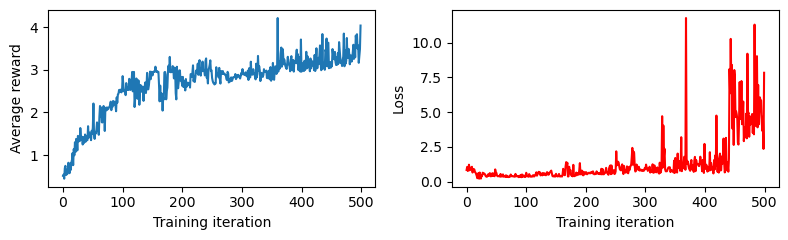

In [24]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [25]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(500, 8)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  BA_A  BA_B  BA_C  \
0  0.519196  0.831985      0.739866      0.092120   0.0   0.0   0.0   
1  0.547417  1.054369      0.963355      0.091014   0.0   0.0   0.0   
2  0.450943  0.763759      0.669278      0.094481   0.0   0.0   0.0   
3  0.696884  0.798286      0.698642      0.099644   0.0   0.0   0.0   
4  0.751209  1.210709      1.112631      0.098078   0.0   0.0   0.0   

    EXEC_TIME  
0   24.883554  
1   50.224881  
2   75.052170  
3  100.414886  
4  126.735792  


In [26]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [27]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████| 30000/30000 [18:14<00:00, 27.40it/s]


In [28]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize_ReBADD/zinc15_scst/smi_after.csv
